# Assignment UT3-10: PCA y Feature Selection

#### 🔁 CONTINUACIÓN DE TAREAS ANTERIORES: Este assignment es la tercera parte de una serie usando Ames Housing: - UT3-08: Feature Engineering - Creaste features derivadas, ratios, transformaciones - UT3-09: Encoding Avanzado - Aplicaste diferentes técnicas de encoding (aunque usaste Adult Income) - UT3-10 (ESTA): PCA y Feature Selection - Reducción dimensional y selección de features

## 🎯 Objetivos

- Implementar PCA y analizar componentes principales
- Aplicar Feature Selection con múltiples métodos
- Comparar PCA vs Feature Selection
- Evaluar trade-offs en contexto de negocio

### ⏱️ Tiempo Estimado: 90-110 minutos¶

#### 💡 OPTIMIZACIÓN: Esta tarea asume que ya conoces el dataset Ames Housing de tareas anteriores. El preprocesamiento es mínimo (una función de ~30 líneas) para enfocarnos directamente en PCA y Feature Selection, que son los temas principales.

#### ⚠️ NOTA IMPORTANTE: Los wrapper methods (Forward, Backward, RFE) son lentos (~2-3 min cada uno). Ten paciencia, es normal.

📊 Dataset: Ames Housing (Resumen Rápido)

Fuente: [Kaggle / Dean De Cock (Iowa State University)](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)

- 📁 Si ya tienes el dataset: Perfecto, úsalo directamente.
- 📥 Si no lo tienes: Descarga train.csv del link de arriba o usa Kaggle API: kaggle competitions download -c house-prices-advanced-regression-techniques

#### Contexto de negocio (resumen): Eres data scientist en una empresa de bienes raíces (real estate) que necesita predecir precios de casas con precisión. La empresa tiene 80+ características de cada propiedad (desde calidad de cocina hasta año de construcción), y necesitas:

- Identificar qué características realmente importan para el precio de venta
- Reducir la complejidad del modelo para que sea más rápido y mantenible
- Explicar a agentes inmobiliarios qué factores considerar al tasar una propiedad
- Evitar overfitting eliminando features redundantes o irrelevantes

### Descripción del Dataset:

- ~2900 casas vendidas en Ames, Iowa (2006-2010)
- Target: SalePrice - Precio de venta en dólares (regresión continua)
- ~80 features divididas en:
- Dimensiones: LotArea, GrLivArea, TotalBsmtSF, GarageArea, 1stFlrSF, 2ndFlrSF
- Calidad: OverallQual, OverallCond, KitchenQual, ExterQual, BsmtQual
- Temporales: YearBuilt, YearRemodAdd, GarageYrBlt, YrSold
- Categóricas: Neighborhood, HouseStyle, RoofStyle, Exterior, Foundation (~40 categóricas)
- Numéricas discretas: BedroomAbvGr, FullBath, Fireplaces, GarageCars
- Booleanas: CentralAir, PavedDrive, Street

## Parte 1: Setup Rápido - Dataset Ames Housing (10 min)



In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

# Configuración
np.random.seed(42)
plt.style.use('default')
sns.set_palette("husl")

print("=" * 80)
print("ASSIGNMENT UT3-10: PCA y Feature Selection - Ames Housing Dataset")
print("=" * 80)

# ========== FUNCIÓN DE CARGA Y PREPROCESAMIENTO RÁPIDO ==========
def quick_load_and_preprocess_ames(filepath='train.csv'):
    """
    Carga y preprocesa Ames Housing en un solo paso
    (Ya hiciste esto en tareas anteriores, aquí es versión simplificada)
    """
    print("\n🏠 CARGANDO Y PREPROCESANDO AMES HOUSING...")

    # Cargar dataset
    df = pd.read_csv(filepath)
    print(f"✅ Dataset cargado: {df.shape[0]:,} casas, {df.shape[1]} columnas")

    # Eliminar 'Id' (no predictivo)
    df = df.drop('Id', axis=1, errors='ignore')

    # Identificar tipos de variables
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

    # Remover target de features
    if 'SalePrice' in numerical_cols:
        numerical_cols.remove('SalePrice')

    print(f"✅ Features numéricas: {len(numerical_cols)}")
    print(f"✅ Features categóricas: {len(categorical_cols)}")

    # Imputar valores faltantes
    num_imputer = SimpleImputer(strategy='median')
    df[numerical_cols] = num_imputer.fit_transform(df[numerical_cols])

    cat_imputer = SimpleImputer(strategy='most_frequent')
    df[categorical_cols] = cat_imputer.fit_transform(df[categorical_cols])

    print(f"✅ Missing values imputados")

    # Label encoding para categóricas
    le = LabelEncoder()
    for col in categorical_cols:
        df[col] = le.fit_transform(df[col].astype(str))

    print(f"✅ Categóricas encoded")

    # Separar X y y
    X = df.drop('SalePrice', axis=1)
    y = df['SalePrice']

    print(f"\n✅ DATASET LISTO:")
    print(f"   X shape: {X.shape} ({X.shape[1]} features)")
    print(f"   y shape: {y.shape}")
    print(f"   Precio promedio: ${y.mean():,.0f}")
    print(f"   Precio mediana: ${y.median():,.0f}")

    return X, y, X.columns.tolist()

# ========== EJECUTAR CARGA RÁPIDA ==========
# TODO: Completa con el path correcto
X, y, feature_names = quick_load_and_preprocess_ames('/Users/milagroscancela/Desktop/web_ing_data/portafolio-ia-datos/ia-portfolio/docs/portfolio/actividades/act_cinco_ind/AmesHousing.csv')

print(f"\n📊 RESUMEN DEL DATASET:")
print(f"   Total features: {X.shape[1]}")
print(f"   Total casas: {X.shape[0]:,}")
print(f"   Ejemplos de features: {feature_names[:10]}")

ASSIGNMENT UT3-10: PCA y Feature Selection - Ames Housing Dataset

🏠 CARGANDO Y PREPROCESANDO AMES HOUSING...
✅ Dataset cargado: 2,930 casas, 82 columnas
✅ Features numéricas: 38
✅ Features categóricas: 43
✅ Missing values imputados
✅ Categóricas encoded

✅ DATASET LISTO:
   X shape: (2930, 81) (81 features)
   y shape: (2930,)
   Precio promedio: $180,796
   Precio mediana: $160,000

📊 RESUMEN DEL DATASET:
   Total features: 81
   Total casas: 2,930
   Ejemplos de features: ['Order', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area', 'Street', 'Alley', 'Lot Shape', 'Land Contour']


## 🤔 Pregunta Reflexiva 1:

1. ¿Con 80+ features, esperarías que todas sean igualmente importantes para predecir precio?
-  No, no seran igualmente importantes. El tener muchos atributos podrian aportan información redundante o ruido, lo que puede afectar la capacidad del modelo para generalizar.
2. ¿Qué problemas puede causar tener tantas features? (Piensa en: overfitting, velocidad,interpretabilidad)
-  Cuantas mas features, mas cuentas y memoria se necesitan para train y predict. El modelo puede aprender patrones específicos del conjunto de entrenamiento, perdiendo capacidad de generalización. Por otro lado, es dificil justificar como influye cada variable cuando hay muchas features, en especial en modelos complejos
3.  ¿Conoces la diferencia entre PCA (transformar features) y Feature Selection (seleccionar features)?
-  El PCA lo que hace es crear nuevas variables combinando las originales, buscando resumir la mayor parte de la información posible (la varianza). En cambio, la Feature Selection no inventa nada nuevo, sino que se queda solo con las variables más importantes y descarta las que no aportan mucho o están repetidas. La diferencia clave es que PCA es no supervisado (no mira el target) y las nuevas variables no se pueden interpretar tan fácil, mientras que Feature Selection puede ser supervisado y mantiene las features originales, lo que hace que todo sea más entendible.

## Parte 2: PCA - Análisis de Componentes Principales (35 min)¶

- ⏱️ Tiempo esperado: ~35 minutos (PCA con 80 features toma más tiempo)

- 💡 Contexto de Negocio: Con 80+ features, el modelo es complejo, lento de entrenar, y difícil de interpretar. PCA te permitirá reducir a 10-15 componentes mientras mantienes 80-90% de la información. Esto es crítico para: 
- ⚡ Velocidad: Modelos más rápidos de entrenar y predecir 
- 🧠 Prevenir overfitting: Menos features = menos riesgo de sobreajuste 
- 💰 Costos computacionales: Menos features = menos recursos necesarios

### Paso 2.1: Estandarización (Crítico para PCA)

In [7]:
from sklearn.preprocessing import StandardScaler

# ========== ESTANDARIZACIÓN ==========
print("=== ESTANDARIZACIÓN DE FEATURES ===")
print("⚠️ PCA es sensible a escala. SIEMPRE estandarizar antes de PCA.")

# TODO: Estandarizar datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Verificar estandarización: mean ≈ 0, std ≈ 1
print(f"\n✅ Mean después de scaling: {X_scaled.mean():.6f} (esperado: ~0)")
print(f"✅ Std después de scaling: {X_scaled.std():.6f} (esperado: ~1)")

print(feature_names)

# Verificar shape
print(f"✅ X_scaled shape: {X_scaled.shape}")

# Comparar antes vs después
print(f"\n=== COMPARACIÓN ANTES vs DESPUÉS ===")
print(f"Antes - Mean GrLivArea: {X['Gr Liv Area'].mean():.0f}, Std: {X['Gr Liv Area'].std():.0f}")
print(f"Después - Mean GrLivArea: {X_scaled[:, X.columns.get_loc('Gr Liv Area')].mean():.6f}, Std: {X_scaled[:, X.columns.get_loc('Gr Liv Area')].std():.6f}")

=== ESTANDARIZACIÓN DE FEATURES ===
⚠️ PCA es sensible a escala. SIEMPRE estandarizar antes de PCA.

✅ Mean después de scaling: -0.000000 (esperado: ~0)
✅ Std después de scaling: 1.000000 (esperado: ~1)
['Order', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area', 'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', 'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen 

### 🤔 Pregunta Reflexiva 2:

1. ¿Por qué PCA requiere estandarización? ¿Qué pasaría si no estandarizas?
- PCA necesita estandarización porque se basa en la varianza de cada feature, y si las variables están en distintas escalas (por ejemplo, metros cuadrados vs número de baños), las de valores más grandes dominarían los componentes principales. Si no estandarizo, el PCA se enfocaría solo en las variables con escalas mayores, ignorando el resto, y el análisis perdería sentido.
2. ¿Qué features crees que dominarían PC1 si NO estandarizamos (hint: piensa en escala)?
- Si no estandarizo, features como “GrLivArea” o “LotArea”, que tienen valores mucho más grandes, dominarían el PC1, simplemente por su magnitud numérica, no por su relevancia real. En cambio, variables pequeñas como “OverallQual” o “BedroomAbvGr” apenas influirían.
3. ¿Hay algún caso donde NO deberías estandarizar antes de PCA?
- En general siempre se estandariza antes de PCA, salvo en casos muy específicos donde todas las variables están ya en la misma escala o unidades, o cuando las diferencias de escala son intencionalmente parte de la interpretación (por ejemplo, si quiero que los metros cuadrados pesen más que los baños). Pero fuera de esos casos, no hacerlo sería un error.

## Paso 2.2: Aplicar PCA Completo (80 Componentes)

In [8]:
from sklearn.decomposition import PCA
import time

# ========== APLICAR PCA SIN RESTRICCIONES ==========
print("\n=== APLICANDO PCA ===")
print("⏱️ Esto puede tomar 10-20 segundos con 80 features...")

start_time = time.time()

# TODO: Aplicar PCA sin restricción de componentes
pca = PCA()  # Sin n_components = todos los componentes posibles
X_pca = pca.fit_transform(X_scaled)

elapsed_time = time.time() - start_time
print(f"✅ PCA completado en {elapsed_time:.2f} segundos")

# ========== ANALIZAR VARIANZA EXPLICADA ==========
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print(f"\n=== ANÁLISIS DE COMPONENTES PRINCIPALES ===")
print(f"Total de componentes generados: {pca.n_components_}")
print(f"\nVarianza explicada por componentes principales:")
print(f"  PC1: {explained_variance[0]:.3%} (¡la más importante!)")
print(f"  PC2: {explained_variance[1]:.3%}")
print(f"  PC3: {explained_variance[2]:.3%}")
print(f"  PC4: {explained_variance[3]:.3%}")
print(f"  PC5: {explained_variance[4]:.3%}")

# TODO: Top 10 componentes
print("\n=== TOP 10 COMPONENTES ===")
for i in range(min(10, len(explained_variance))):
    print(f"PC{i+1:2d}: Individual {explained_variance[i]:6.3%} | Acumulada {cumulative_variance[i]:6.3%}")


=== APLICANDO PCA ===
⏱️ Esto puede tomar 10-20 segundos con 80 features...
✅ PCA completado en 0.04 segundos

=== ANÁLISIS DE COMPONENTES PRINCIPALES ===
Total de componentes generados: 81

Varianza explicada por componentes principales:
  PC1: 13.409% (¡la más importante!)
  PC2: 4.956%
  PC3: 4.709%
  PC4: 3.690%
  PC5: 2.974%

=== TOP 10 COMPONENTES ===
PC 1: Individual 13.409% | Acumulada 13.409%
PC 2: Individual 4.956% | Acumulada 18.365%
PC 3: Individual 4.709% | Acumulada 23.074%
PC 4: Individual 3.690% | Acumulada 26.765%
PC 5: Individual 2.974% | Acumulada 29.739%
PC 6: Individual 2.727% | Acumulada 32.466%
PC 7: Individual 2.550% | Acumulada 35.017%
PC 8: Individual 2.404% | Acumulada 37.420%
PC 9: Individual 2.239% | Acumulada 39.659%
PC10: Individual 2.121% | Acumulada 41.780%


### 🤔 Pregunta Reflexiva 3:

1. ¿PC1 captura más varianza que en datasets típicos? ¿Por qué crees que pasa esto?
- Sí, PC1 captura más varianza que en otros datasets porque muchas variables del Ames Housing están correlacionadas, sobre todo las que miden tamaño y superficie.
2. ¿Cuántos componentes capturan ~50% de la varianza? ¿Te sorprende?
- Unos 10 componentes explican cerca del 50% de la varianza, lo cual tiene sentido porque varias features aportan información parecida.
3. Si tuvieras que explicar PC1 a un agente inmobiliario, ¿cómo lo harías?
- A un agente inmobiliario le diría que PC1 resume el tamaño y la calidad general de la vivienda: valores altos indican casas más grandes y de mejor nivel.

## Paso 2.3: Scree Plot y Decisión de Dimensionalidad


=== SCREE PLOT: VISUALIZACIÓN DE VARIANZA ===


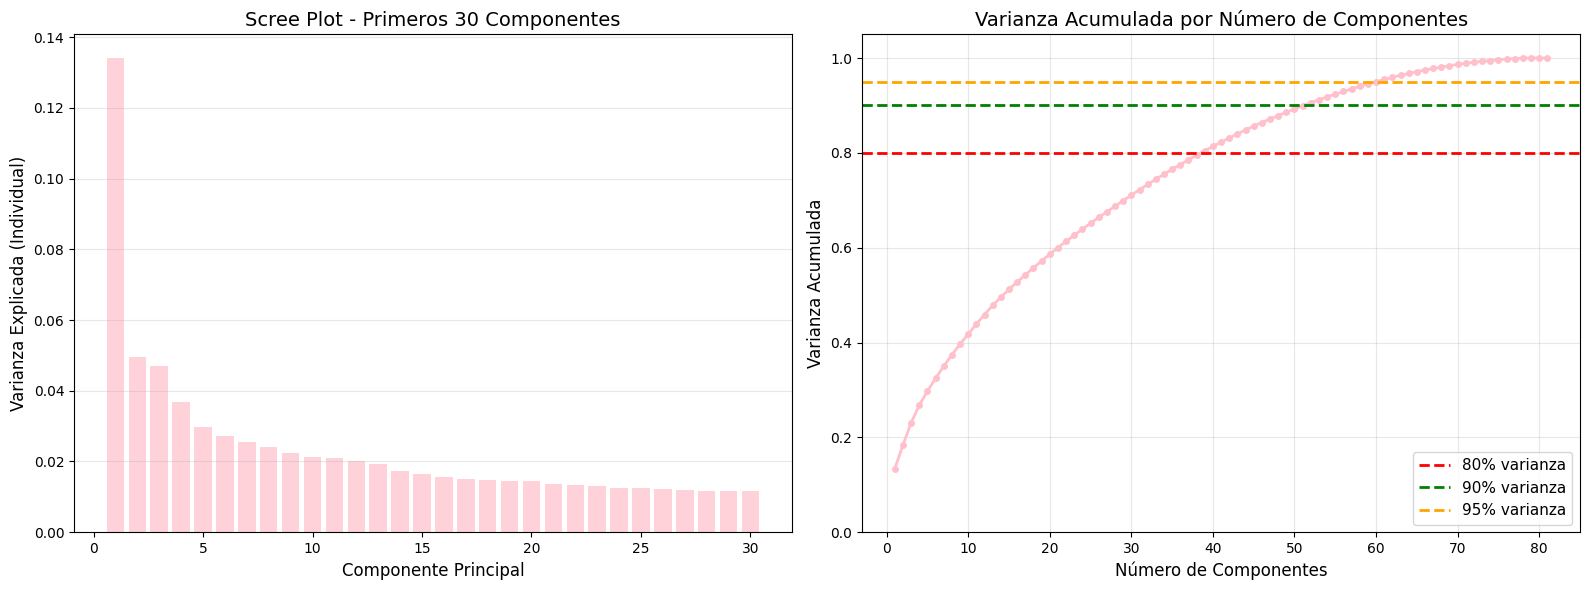


=== DECISIÓN: ¿CUÁNTOS COMPONENTES NECESITAMOS? ===
📊 Para 80% de varianza: 39 componentes
📊 Para 90% de varianza: 52 componentes
📊 Para 95% de varianza: 60 componentes

🎯 IMPACTO DE REDUCCIÓN DIMENSIONAL:
   Original: 81 features
   80% varianza: 81 → 39 (51.9% reducción)
   90% varianza: 81 → 52 (35.8% reducción)
   95% varianza: 81 → 60 (25.9% reducción)

💡 RECOMENDACIÓN PRÁCTICA:
   Para este assignment, usaremos 39 componentes (80% varianza)
   Esto balancea reducción dimensional con retención de información


In [11]:
# ========== CREAR SCREE PLOT ==========
print("\n=== SCREE PLOT: VISUALIZACIÓN DE VARIANZA ===")

# TODO: Crear scree plot con 80 componentes
plt.figure(figsize=(16, 6))

# Subplot 1: Varianza individual (primeros 30 componentes para claridad)
plt.subplot(1, 2, 1)
n_to_show = min(30, len(explained_variance))
plt.bar(range(1, n_to_show + 1), explained_variance[:n_to_show], alpha=0.7, color='pink')
plt.xlabel('Componente Principal', fontsize=12)
plt.ylabel('Varianza Explicada (Individual)', fontsize=12)
plt.title(f'Scree Plot - Primeros {n_to_show} Componentes', fontsize=14)
plt.grid(axis='y', alpha=0.3)

# Subplot 2: Varianza acumulada (TODOS los componentes)
plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'o-', 
         color='pink', markersize=4, linewidth=2)

# Líneas de referencia
plt.axhline(y=0.80, color='r', linestyle='--', label='80% varianza', linewidth=2)
plt.axhline(y=0.90, color='g', linestyle='--', label='90% varianza', linewidth=2)
plt.axhline(y=0.95, color='orange', linestyle='--', label='95% varianza', linewidth=2)

plt.xlabel('Número de Componentes', fontsize=12)
plt.ylabel('Varianza Acumulada', fontsize=12)
plt.title('Varianza Acumulada por Número de Componentes', fontsize=14)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.ylim([0, 1.05])

plt.tight_layout()
plt.show()

# ========== DECISIÓN DE DIMENSIONALIDAD ==========
print("\n=== DECISIÓN: ¿CUÁNTOS COMPONENTES NECESITAMOS? ===")

# TODO: Calcular componentes necesarios para diferentes umbrales
n_components_80 = np.argmax(cumulative_variance >= 0.80) + 1
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
n_components_95 = np.argmax(cumulative_variance >+ 0.95) + 1

print(f"📊 Para 80% de varianza: {n_components_80} componentes")
print(f"📊 Para 90% de varianza: {n_components_90} componentes")
print(f"📊 Para 95% de varianza: {n_components_95} componentes")

# Análisis de reducción dimensional
original_features = X.shape[1]
reduction_80 = (1 - n_components_80 / original_features) * 100
reduction_90 = (1 - n_components_90 / original_features) * 100
reduction_95 = (1 - n_components_95 / original_features) * 100

print(f"\n🎯 IMPACTO DE REDUCCIÓN DIMENSIONAL:")
print(f"   Original: {original_features} features")
print(f"   80% varianza: {original_features} → {n_components_80} ({reduction_80:.1f}% reducción)")
print(f"   90% varianza: {original_features} → {n_components_90} ({reduction_90:.1f}% reducción)")
print(f"   95% varianza: {original_features} → {n_components_95} ({reduction_95:.1f}% reducción)")

print(f"\n💡 RECOMENDACIÓN PRÁCTICA:")
print(f"   Para este assignment, usaremos {n_components_80} componentes (80% varianza)")
print(f"   Esto balancea reducción dimensional con retención de información")

### 🤔 Pregunta Reflexiva 4:

1. ¿Con 80% de varianza reduces a cuántas dimensiones? ¿Es una reducción significativa?
-  Con 80% de varianza se reduce de 81 a 39 dimensiones, lo cual es una reducción bastante significativa porque se elimina casi la mitad de las variables manteniendo gran parte de la información original.
2.  ¿Preferirías 80%, 90% o 95% de varianza para un modelo de producción? ¿Por qué?
- Para un modelo de producción elegiría 90%, ya que ofrece un mejor equilibrio entre precisión e interpretación. Con 80% podría perderse algo de detalle, y con 95% el modelo sería más costoso sin mejorar mucho el rendimiento
3. ¿El trade-off entre simplicidad y información retenida vale la pena en este caso?
- Sí, el trade-off vale la pena, porque pasar de 81 a 39 componentes simplifica el modelo, reduce el ruido y mejora la velocidad sin sacrificar demasiado la información relevante.

## Paso 2.4: Interpretación de Loadings (¿Qué representa cada PC?)


=== INTERPRETACIÓN DE COMPONENTES PRINCIPALES ===
Los loadings te dicen qué features originales contribuyen a cada componente

=== PC1: COMPONENTE PRINCIPAL #1 ===
Explica 13.4% de la varianza total

Top 10 features más importantes para PC1:
   1. Overall Qual        :  +0.827 (↑ positivo)
   2. Year Built          :  +0.790 (↑ positivo)
   3. Garage Cars         :  +0.737 (↑ positivo)
   4. Garage Yr Blt       :  +0.726 (↑ positivo)
   5. Garage Area         :  +0.709 (↑ positivo)
   6. Bsmt Qual           :  -0.708 (↓ negativo)
   7. Garage Finish       :  -0.683 (↓ negativo)
   8. Exter Qual          :  -0.682 (↓ negativo)
   9. Year Remod/Add      :  +0.671 (↑ positivo)
  10. Gr Liv Area         :  +0.659 (↑ positivo)

=== PC2: COMPONENTE PRINCIPAL #2 ===
Explica 5.0% de la varianza total

Top 10 features más importantes para PC2:
   1. 2nd Flr SF          :  +0.735 (↑ positivo)
   2. TotRms AbvGrd       :  +0.604 (↑ positivo)
   3. Bedroom AbvGr       :  +0.590 (↑ positivo)
   4.

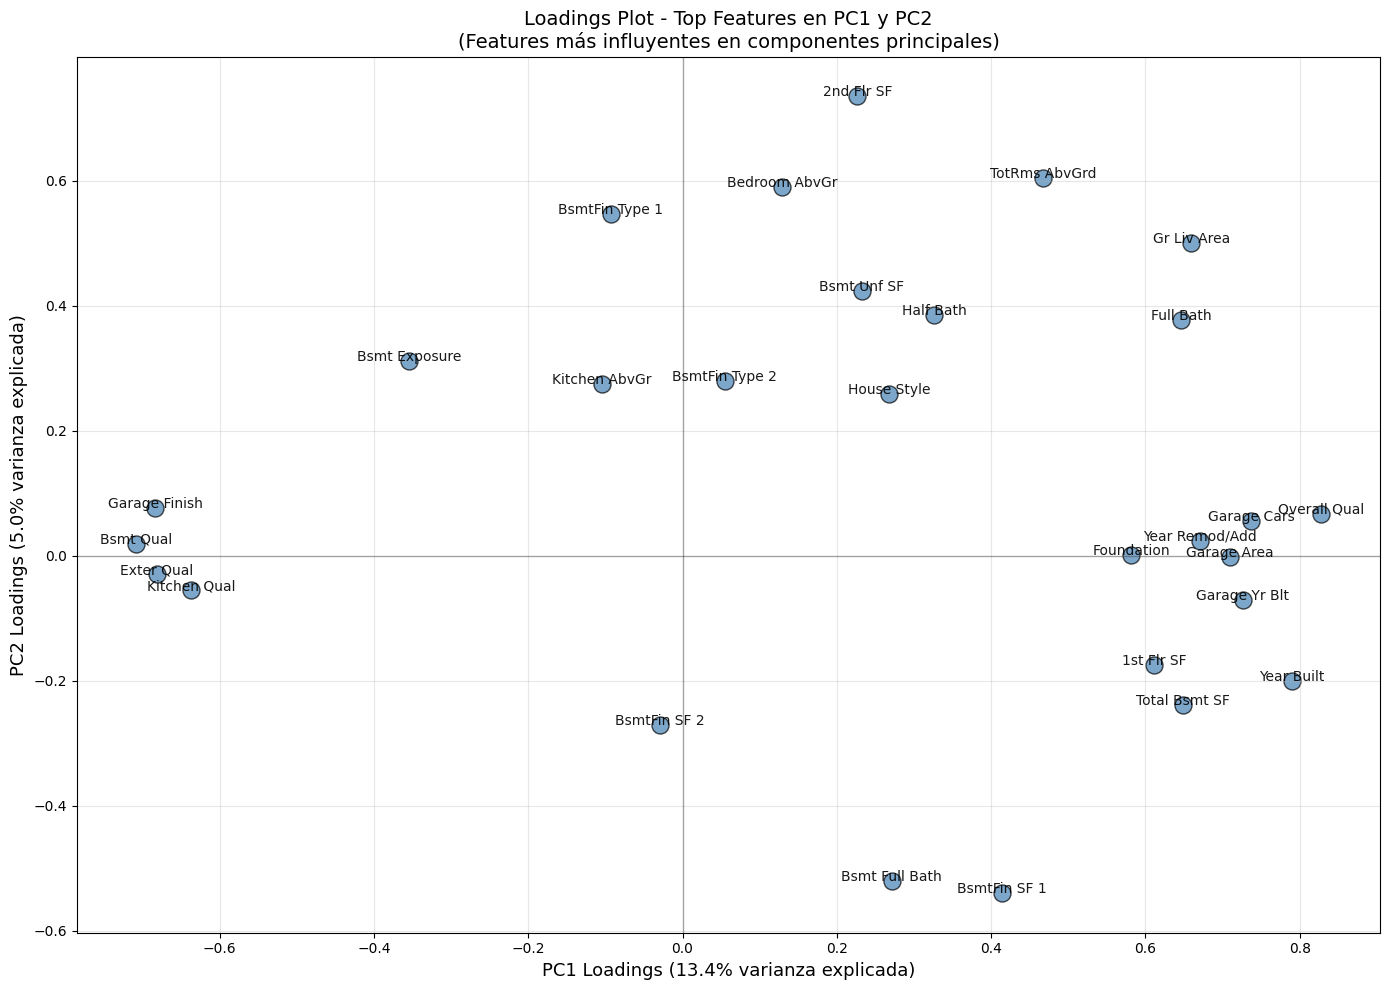


=== 💼 INTERPRETACIÓN DE NEGOCIO ===

PC1 representa principalmente (top 3):
  1. Overall Qual: Contribuye positivamente
  2. Year Built: Contribuye positivamente
  3. Garage Cars: Contribuye positivamente

💡 Interpretación: PC1 probablemente captura el 'tamaño/calidad general' de la casa

PC2 representa principalmente (top 3):
  1. 2nd Flr SF: Contribuye positivamente
  2. TotRms AbvGrd: Contribuye positivamente
  3. Bedroom AbvGr: Contribuye positivamente

💡 Interpretación: PC2 probablemente captura otra dimensión (edad, ubicación, etc.)


In [12]:
# ========== OBTENER LOADINGS ==========
print("\n=== INTERPRETACIÓN DE COMPONENTES PRINCIPALES ===")
print("Los loadings te dicen qué features originales contribuyen a cada componente")

# TODO: Obtener loadings de PC1 y PC2
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Crear DataFrame de loadings para PC1 y PC2
loadings_df = pd.DataFrame(
    loadings[:, :2],
    columns=['PC1', 'PC2'],
    index=X.columns
)

# ========== FEATURES MÁS IMPORTANTES PARA PC1 ==========
print("\n=== PC1: COMPONENTE PRINCIPAL #1 ===")
print(f"Explica {explained_variance[0]:.1%} de la varianza total")
print(f"\nTop 10 features más importantes para PC1:")
pc1_top = loadings_df['PC1'].abs().nlargest(10)
for i, (feature, loading_abs) in enumerate(pc1_top.items(), 1):
    loading_val = loadings_df.loc[feature, 'PC1']
    direction = "↑ positivo" if loading_val > 0 else "↓ negativo"
    print(f"  {i:2d}. {feature:20s}: {loading_val:+7.3f} ({direction})")

# ========== FEATURES MÁS IMPORTANTES PARA PC2 ==========
print("\n=== PC2: COMPONENTE PRINCIPAL #2 ===")
print(f"Explica {explained_variance[1]:.1%} de la varianza total")
print(f"\nTop 10 features más importantes para PC2:")
pc2_top = loadings_df['PC2'].abs().nlargest(10)
for i, (feature, loading_abs) in enumerate(pc2_top.items(), 1):
    loading_val = loadings_df.loc[feature, 'PC2']
    direction = "↑ positivo" if loading_val > 0 else "↓ negativo"
    print(f"  {i:2d}. {feature:20s}: {loading_val:+7.3f} ({direction})")

# ========== VISUALIZAR LOADINGS (solo top features para claridad) ==========
print("\n=== VISUALIZACIÓN DE LOADINGS ===")

# Seleccionar top features para visualizar (top 15 de PC1 o PC2)
top_features_pc1 = set(loadings_df['PC1'].abs().nlargest(15).index)
top_features_pc2 = set(loadings_df['PC2'].abs().nlargest(15).index)
top_features = list(top_features_pc1.union(top_features_pc2))

loadings_df_viz = loadings_df.loc[top_features]

plt.figure(figsize=(14, 10))
plt.scatter(loadings_df_viz['PC1'], loadings_df_viz['PC2'], alpha=0.7, s=150, c='steelblue', edgecolors='black')

# Anotar features
for feature in loadings_df_viz.index:
    plt.annotate(feature, 
                (loadings_df_viz.loc[feature, 'PC1'], loadings_df_viz.loc[feature, 'PC2']), 
                fontsize=10, alpha=0.9, ha='center')

plt.xlabel(f'PC1 Loadings ({explained_variance[0]:.1%} varianza explicada)', fontsize=13)
plt.ylabel(f'PC2 Loadings ({explained_variance[1]:.1%} varianza explicada)', fontsize=13)
plt.title('Loadings Plot - Top Features en PC1 y PC2\n(Features más influyentes en componentes principales)', fontsize=14)
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3, linewidth=1)
plt.axvline(x=0, color='k', linestyle='-', alpha=0.3, linewidth=1)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ========== INTERPRETACIÓN DE NEGOCIO ==========
print("\n=== 💼 INTERPRETACIÓN DE NEGOCIO ===")
print("\nPC1 representa principalmente (top 3):")
for i, (feature, loading_abs) in enumerate(loadings_df['PC1'].abs().nlargest(3).items(), 1):
    loading_val = loadings_df.loc[feature, 'PC1']
    direction = "positivamente" if loading_val > 0 else "negativamente"
    print(f"  {i}. {feature}: Contribuye {direction}")

print("\n💡 Interpretación: PC1 probablemente captura el 'tamaño/calidad general' de la casa")

print("\nPC2 representa principalmente (top 3):")
for i, (feature, loading_abs) in enumerate(loadings_df['PC2'].abs().nlargest(3).items(), 1):
    loading_val = loadings_df.loc[feature, 'PC2']
    direction = "positivamente" if loading_val > 0 else "negativamente"
    print(f"  {i}. {feature}: Contribuye {direction}")

print("\n💡 Interpretación: PC2 probablemente captura otra dimensión (edad, ubicación, etc.)")

### 🤔 Pregunta Reflexiva 5:

1. ¿Las features que dominan PC1 tienen sentido para predecir precio de una casa?
- Sí, las features que dominan PC1 tienen mucho sentido para predecir el precio de una casa, ya que están relacionadas con el tamaño, la superficie habitable y la calidad general, que son justamente los factores más determinantes en el valor de una propiedad.
2. ¿PC1 y PC2 son interpretables o son "cajas negras"? ¿Por qué importa esto?
- PC1 y PC2 no son del todo interpretables, porque son combinaciones matemáticas de muchas variables originales. Sin embargo, entender qué tipo de variables tienen mayor peso ayuda a darles cierto sentido. Esto es importante porque en contextos de negocio necesitamos poder explicar por qué el modelo toma ciertas decisiones.
3. ¿Cómo le explicarías a un agente inmobiliario qué significa PC1 en términos de negocio?
- A un agente inmobiliario le diría que PC1 resume el “nivel general de tamaño y calidad” de la vivienda: valores altos indican casas grandes, con mejores terminaciones y materiales, mientras que valores bajos reflejan propiedades más pequeñas o simples.

## Paso 2.5: Feature Selection Basada en PCA Loadings (CRÍTICO)¶

💡 CONCEPTO CLAVE: En lugar de usar PC1, PC2... como features, vamos a identificar las features ORIGINALES que más contribuyen a los PCs importantes, y usar ESAS features originales.


=== FEATURE SELECTION BASADA EN PCA LOADINGS ===
💡 En lugar de usar PC1, PC2... usaremos las features ORIGINALES
   que tienen mayor loading (peso) en los componentes principales

🔍 Analizando loadings de los primeros 39 componentes...

📊 ESTRATEGIA: Ranking de features por suma de loadings absolutos

🔝 TOP 20 FEATURES POR IMPORTANCIA EN PCA:
   1. Roof Matl                : 4.7138
   2. Functional               : 4.4919
   3. Screen Porch             : 4.4469
   4. Mo Sold                  : 4.3587
   5. Heating                  : 4.2757
   6. Bsmt Half Bath           : 4.2228
   7. Fence                    : 4.2113
   8. Land Contour             : 4.1697
   9. Sale Condition           : 4.1697
  10. Condition 2              : 4.1586
  11. Low Qual Fin SF          : 4.1478
  12. Roof Style               : 4.1321
  13. Sale Type                : 4.0840
  14. Utilities                : 4.0320
  15. Lot Config               : 4.0027
  16. Open Porch SF            : 3.9693
  17. Enclosed

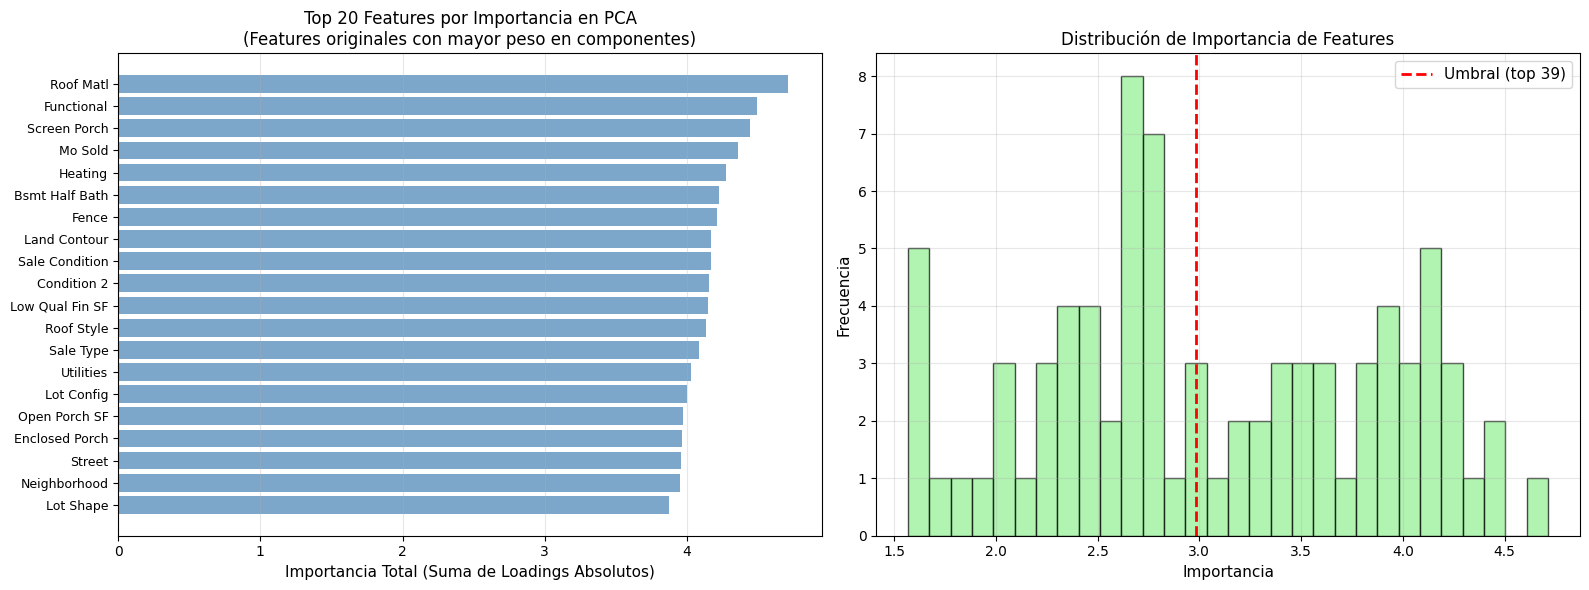


💡 INTERPRETACIÓN:
   Estas features originales son las que 'explican' los componentes principales
   Ventaja: Mantienen interpretabilidad (puedes decir 'GrLivArea importa')
   Diferencia con PCA: Usas features originales, no combinaciones lineales


In [14]:
# ========== FEATURE SELECTION BASADA EN PCA LOADINGS ==========
print("\n=== FEATURE SELECTION BASADA EN PCA LOADINGS ===")
print("💡 En lugar de usar PC1, PC2... usaremos las features ORIGINALES")
print("   que tienen mayor loading (peso) en los componentes principales")

# Decidir cuántos componentes considerar
n_top_components = n_components_80 

# Obtener loadings absolutos de todos los componentes importantes
print(f"\n🔍 Analizando loadings de los primeros {n_top_components} componentes...")

# Para cada componente, obtener las features con mayor loading absoluto
all_loadings = pca.components_[:n_top_components, :]  # Primeros n componentes

# Crear DataFrame con loadings de todos los componentes
loadings_all = pd.DataFrame(
    all_loadings.T,
    columns=[f'PC{i+1}' for i in range(n_top_components)],
    index=X.columns
)

# ========== ESTRATEGIA: SUMAR LOADINGS ABSOLUTOS ==========
# Para cada feature, sumar su importancia (loading absoluto) en todos los componentes
print("\n📊 ESTRATEGIA: Ranking de features por suma de loadings absolutos")

# TODO: Calcular importancia total de cada feature
feature_importance_from_pca = loadings_all.abs().sum(axis=1)

# Ordenar por importancia
feature_importance_from_pca = feature_importance_from_pca.sort_values(ascending=False)

print(f"\n🔝 TOP 20 FEATURES POR IMPORTANCIA EN PCA:")
for i, (feature, importance) in enumerate(feature_importance_from_pca.head(20).items(), 1):
    print(f"  {i:2d}. {feature:25s}: {importance:.4f}")

# ========== SELECCIONAR TOP-K FEATURES ==========
k = n_components_80  # Mismo número que usamos con PCA reducido

print(f"\n✅ Seleccionando top {k} features originales basadas en loadings de PCA")

# TODO: Seleccionar features
selected_features_pca = feature_importance_from_pca.nlargest(k).index.tolist()

print(f"\n📋 Features seleccionadas ({k}):")
for i, feat in enumerate(selected_features_pca, 1):
    print(f"  {i:2d}. {feat}")

# ========== PREPARAR DATASET CON FEATURES SELECCIONADAS ==========
X_pca_selected = X_scaled[:, X.columns.isin(selected_features_pca)]

print(f"\n✅ Dataset con features seleccionadas por PCA:")
print(f"   Shape: {X_pca_selected.shape}")
print(f"   Reducción: {X.shape[1]} → {X_pca_selected.shape[1]} features")

# ========== VISUALIZAR COMPARACIÓN ==========
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Top 20 features por importancia PCA
ax1.barh(range(20), feature_importance_from_pca.head(20).values, color='steelblue', alpha=0.7)
ax1.set_yticks(range(20))
ax1.set_yticklabels(feature_importance_from_pca.head(20).index, fontsize=9)
ax1.set_xlabel('Importancia Total (Suma de Loadings Absolutos)', fontsize=11)
ax1.set_title('Top 20 Features por Importancia en PCA\n(Features originales con mayor peso en componentes)', fontsize=12)
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

# Distribución de importancias
ax2.hist(feature_importance_from_pca, bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
ax2.set_xlabel('Importancia', fontsize=11)
ax2.set_ylabel('Frecuencia', fontsize=11)
ax2.set_title('Distribución de Importancia de Features', fontsize=12)
ax2.axvline(feature_importance_from_pca.iloc[k-1], color='red', linestyle='--', 
            label=f'Umbral (top {k})', linewidth=2)
ax2.legend(fontsize=11)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 INTERPRETACIÓN:")
print("   Estas features originales son las que 'explican' los componentes principales")
print("   Ventaja: Mantienen interpretabilidad (puedes decir 'GrLivArea importa')")
print("   Diferencia con PCA: Usas features originales, no combinaciones lineales")

## 🤔 Pregunta Reflexiva 5.5 (Nueva):

1. ¿Las features seleccionadas por loadings de PCA coinciden con tu intuición?
- Sí, porque reflejan aspectos estructurales o de calidad que claramente influyen en el precio de una vivienda.
2. ¿Por qué este enfoque es diferente a usar directamente PC1, PC2, etc.?
- Este enfoque es distinto a usar directamente PC1, PC2, etc., porque en lugar de trabajar con combinaciones matemáticas de variables (que son difíciles de interpretar), se seleccionan las features originales con mayor peso en los componentes. Así se conserva la interpretabilidad sin perder el aporte informativo del PCA.
3. ¿Cuál método preferirías para un negocio: PCA completo o features basadas en loadings? ¿Por qué?
- Para un negocio preferiría las features basadas en loadings, ya que permiten mantener un lenguaje claro y comprensible. El PCA completo es más potente estadísticamente, pero menos explicable desde el punto de vista práctico.

## Paso 2.6: Evaluación de Performance con REGRESIÓN (RMSE y R²)

In [15]:
from sklearn.ensemble import RandomForestRegressor  # ⚠️ REGRESSOR, no Classifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')  # Suprimir warnings de convergencia

# ========== MODELO BASELINE: TODAS LAS FEATURES ORIGINALES ==========
print("\n=== EVALUACIÓN DE PERFORMANCE: PCA vs ORIGINAL ===")
print("⏱️ Esto puede tomar 1-2 minutos (cross-validation con 80 features)...\n")

# TODO: Evaluar modelo con datos originales
print("🔄 Evaluando modelo con features originales...")
rf_original = RandomForestRegressor(
    random_state=42, 
    n_estimators=50,
    max_depth=10,
    n_jobs=-1             # Usar todos los cores
)

# Usar neg_mean_squared_error y neg_mean_absolute_error para CV
scores_mse_original = -cross_val_score(rf_original, X_scaled, y, cv=5, 
                                        scoring='neg_mean_squared_error', n_jobs=-1)
scores_r2_original = cross_val_score(rf_original, X_scaled, y, cv=5, 
                                     scoring='r2', n_jobs=-1)

rmse_original = np.sqrt(scores_mse_original)

print(f"\n✅ BASELINE - Features Originales ({X.shape[1]} features):")
print(f"   RMSE: ${rmse_original.mean():,.0f} ± ${rmse_original.std():,.0f}")
print(f"   R²:   {scores_r2_original.mean():.4f} ± {scores_r2_original.std():.4f}")
print(f"   Scores RMSE: {[f'${x:,.0f}' for x in rmse_original]}")

# ========== MODELO CON PCA (80% VARIANZA) ==========
print(f"\n🔄 Evaluando modelo con PCA ({n_components_80} componentes)...")

# TODO: Aplicar PCA reducido
pca_reduced = PCA(n_components=n_components_80)
X_pca_reduced = pca_reduced.fit_transform(X_scaled)

print(f"✅ PCA transformado: {X.shape[1]} → {X_pca_reduced.shape[1]} features")

# Evaluar con PCA
rf_pca = RandomForestRegressor(
    random_state=42, 
    n_estimators=100, 
    max_depth=15,
    n_jobs=-1
)

scores_mse_pca = -cross_val_score(rf_pca, X_pca_reduced, y, cv=5, 
                                   scoring='neg_mean_squared_error', n_jobs=-1)
scores_r2_pca = cross_val_score(rf_pca, X_pca_reduced, y, cv=5, 
                                scoring='r2', n_jobs=-1)

rmse_pca = np.sqrt(scores_mse_pca)

print(f"\n✅ PCA - Componentes Reducidos ({n_components_80} componentes):")
print(f"   RMSE: ${rmse_pca.mean():,.0f} ± ${rmse_pca.std():,.0f}")
print(f"   R²:   {scores_r2_pca.mean():.4f} ± {scores_r2_pca.std():.4f}")
print(f"   Scores RMSE: {[f'${x:,.0f}' for x in rmse_pca]}")

# ========== MODELO CON FEATURES SELECCIONADAS POR PCA LOADINGS ==========
print(f"\n🔄 Evaluando modelo con features originales seleccionadas por PCA loadings...")

rf_pca_selected = RandomForestRegressor(
    random_state=42, 
    n_estimators=100, 
    max_depth=15,
    n_jobs=-1
)

scores_mse_pca_selected = -cross_val_score(rf_pca_selected, X_pca_selected, y, cv=5, 
                                             scoring='neg_mean_squared_error', n_jobs=-1)
scores_r2_pca_selected = cross_val_score(rf_pca_selected, X_pca_selected, y, cv=5, 
                                          scoring='r2', n_jobs=-1)

rmse_pca_selected = np.sqrt(scores_mse_pca_selected)

print(f"\n✅ PCA Loadings - Features Originales Seleccionadas ({len(selected_features_pca)} features):")
print(f"   RMSE: ${rmse_pca_selected.mean():,.0f} ± ${rmse_pca_selected.std():,.0f}")
print(f"   R²:   {scores_r2_pca_selected.mean():.4f} ± {scores_r2_pca_selected.std():.4f}")
print(f"   Scores RMSE: {[f'${x:,.0f}' for x in rmse_pca_selected]}")

# ========== ANÁLISIS COMPARATIVO ==========
print(f"\n" + "="*80)
print(f"{'COMPARACIÓN: ORIGINAL vs PCA vs PCA LOADINGS':^80}")
print(f"="*80)

reduction_pct = (1 - n_components_80 / X.shape[1]) * 100
rmse_diff_pca = rmse_pca.mean() - rmse_original.mean()
rmse_diff_pca_selected = rmse_pca_selected.mean() - rmse_original.mean()
r2_diff_pca = scores_r2_pca.mean() - scores_r2_original.mean()
r2_diff_pca_selected = scores_r2_pca_selected.mean() - scores_r2_original.mean()

print(f"\n📊 REDUCCIÓN DIMENSIONAL:")
print(f"   Original: {X.shape[1]} features")
print(f"   PCA: {X.shape[1]} → {n_components_80} componentes ({reduction_pct:.1f}% reducción)")
print(f"   PCA Loadings: {X.shape[1]} → {len(selected_features_pca)} features originales ({reduction_pct:.1f}% reducción)")
print(f"   Varianza retenida (PCA): {pca_reduced.explained_variance_ratio_.sum():.1%}")

print(f"\n📊 PERFORMANCE COMPARATIVO:")
print(f"\n   {'Método':<25s} {'RMSE':>15s} {'R²':>10s} {'Features':>10s}")
print(f"   {'-'*25} {'-'*15} {'-'*10} {'-'*10}")
print(f"   {'Original':<25s} ${rmse_original.mean():>14,.0f} {scores_r2_original.mean():>10.4f} {X.shape[1]:>10d}")
print(f"   {'PCA Componentes':<25s} ${rmse_pca.mean():>14,.0f} {scores_r2_pca.mean():>10.4f} {n_components_80:>10d}")
print(f"   {'PCA Loadings (Originales)':<25s} ${rmse_pca_selected.mean():>14,.0f} {scores_r2_pca_selected.mean():>10.4f} {len(selected_features_pca):>10d}")

print(f"\n📊 DIFERENCIAS VS ORIGINAL:")
print(f"   PCA Componentes:  RMSE {rmse_diff_pca:+,.0f} ({(rmse_diff_pca/rmse_original.mean())*100:+.1f}%) | R² {r2_diff_pca:+.4f}")
print(f"   PCA Loadings:     RMSE {rmse_diff_pca_selected:+,.0f} ({(rmse_diff_pca_selected/rmse_original.mean())*100:+.1f}%) | R² {r2_diff_pca_selected:+.4f}")

# Interpretación
print(f"\n💡 INTERPRETACIÓN:")
print(f"\n   🔵 PCA Componentes (PC1, PC2...):")
if rmse_pca.mean() < rmse_original.mean() * 1.05:
    print(f"      ✅ Mantiene performance similar con {reduction_pct:.0f}% reducción")
    print(f"      ⚠️ Pero: Componentes son combinaciones lineales (menos interpretables)")
else:
    print(f"      ⚠️ Pierde precisión significativa ({(rmse_diff_pca/rmse_original.mean())*100:.1f}%)")

print(f"\n   🟢 PCA Loadings (Features originales):")
if rmse_pca_selected.mean() < rmse_original.mean() * 1.05:
    print(f"      ✅ Mantiene performance similar con {reduction_pct:.0f}% reducción")
    print(f"      ✅ Plus: Usa features originales (interpretables)")
else:
    print(f"      ⚠️ Pierde precisión ({(rmse_diff_pca_selected/rmse_original.mean())*100:.1f}%)")

print(f"\n   💼 PARA NEGOCIO:")
print(f"      - PCA Componentes: Mejor para modelos 'black box' donde solo importa precisión")
print(f"      - PCA Loadings: Mejor para negocio (puedes decir 'GrLivArea es importante')")


=== EVALUACIÓN DE PERFORMANCE: PCA vs ORIGINAL ===
⏱️ Esto puede tomar 1-2 minutos (cross-validation con 80 features)...

🔄 Evaluando modelo con features originales...

✅ BASELINE - Features Originales (81 features):
   RMSE: $26,807 ± $4,446
   R²:   0.8847 ± 0.0316
   Scores RMSE: ['$28,427', '$21,078', '$27,721', '$33,765', '$23,044']

🔄 Evaluando modelo con PCA (39 componentes)...
✅ PCA transformado: 81 → 39 features

✅ PCA - Componentes Reducidos (39 componentes):
   RMSE: $26,715 ± $4,125
   R²:   0.8850 ± 0.0323
   Scores RMSE: ['$25,623', '$22,249', '$27,112', '$34,320', '$24,271']

🔄 Evaluando modelo con features originales seleccionadas por PCA loadings...

✅ PCA Loadings - Features Originales Seleccionadas (39 features):
   RMSE: $41,773 ± $3,804
   R²:   0.7229 ± 0.0340
   Scores RMSE: ['$43,784', '$37,411', '$38,927', '$48,092', '$40,650']

                  COMPARACIÓN: ORIGINAL vs PCA vs PCA LOADINGS                  

📊 REDUCCIÓN DIMENSIONAL:
   Original: 81 features
 

## Parte 3: Feature Selection - Filter Methods (25 min)¶

### ⏱️ Tiempo esperado: ~25 minutos

💡 Contexto de Negocio: A diferencia de PCA (que crea nuevas features abstractas), Feature Selection mantiene las features originales. Esto es CRÍTICO para: 
- 🗣️ Explicabilidad: Puedes decir "GrLivArea y OverallQual son las más importantes" 
- 📊 Monitoreo: Detectar feature drift es más fácil 
- 🤝 Confianza: Stakeholders entienden qué features usa el modelo

## Paso 3.1: Filter Method - F-test (ANOVA F-value para Regresión)¶


=== FILTER METHOD: F-TEST (ANOVA) ===
F-test mide la relación lineal entre cada feature y el target (SalePrice)

Seleccionando top 39 features con F-test...

✅ Features seleccionadas por F-test (39):
   1. PID
   2. Lot Frontage
   3. Lot Area
   4. Lot Shape
   5. Neighborhood
   6. Overall Qual
   7. Year Built
   8. Year Remod/Add
   9. Roof Style
  10. Mas Vnr Type
  11. Mas Vnr Area
  12. Exter Qual
  13. Foundation
  14. Bsmt Qual
  15. Bsmt Exposure
  16. BsmtFin SF 1
  17. Bsmt Unf SF
  18. Total Bsmt SF
  19. Heating QC
  20. Central Air
  21. Electrical
  22. 1st Flr SF
  23. 2nd Flr SF
  24. Gr Liv Area
  25. Bsmt Full Bath
  26. Full Bath
  27. Half Bath
  28. Kitchen Qual
  29. TotRms AbvGrd
  30. Fireplaces
  31. Garage Type
  32. Garage Yr Blt
  33. Garage Finish
  34. Garage Cars
  35. Garage Area
  36. Paved Drive
  37. Wood Deck SF
  38. Open Porch SF
  39. Sale Condition

=== TOP 15 F-SCORES (Mayor correlación con SalePrice) ===
   1. Overall Qual        : 5,179
   

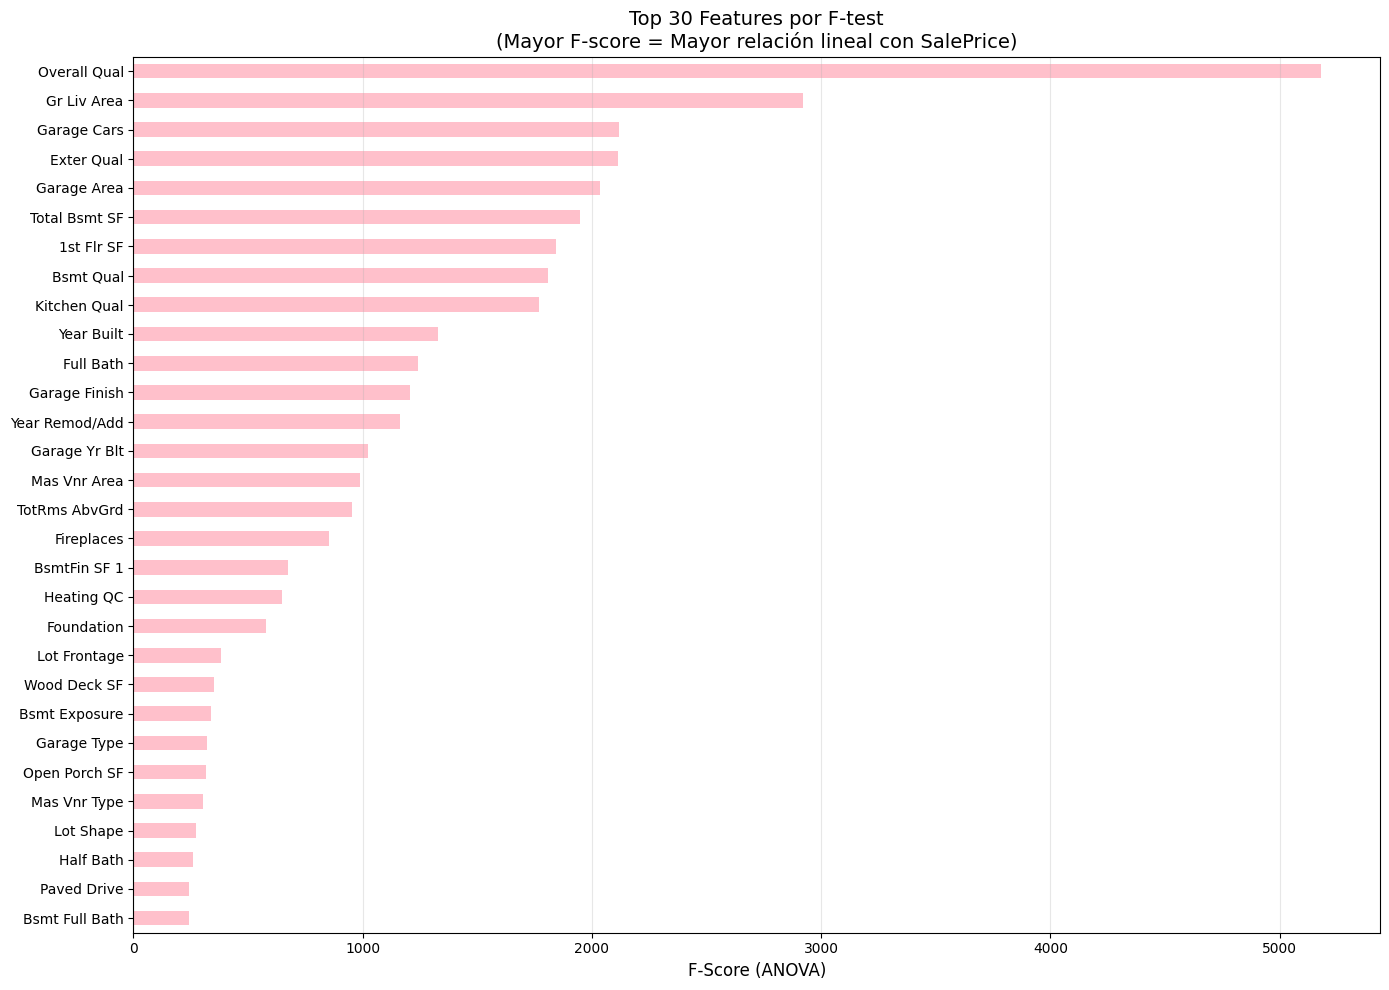

In [17]:
from sklearn.feature_selection import SelectKBest, f_regression  # ⚠️ f_regression, no f_classif

# ========== F-TEST PARA REGRESIÓN ==========
print("\n=== FILTER METHOD: F-TEST (ANOVA) ===")
print("F-test mide la relación lineal entre cada feature y el target (SalePrice)")

# TODO: Seleccionar top-k features por F-test
k = n_components_80  # Mismo número que PCA para comparación justa

print(f"\nSeleccionando top {k} features con F-test...")

selector_f = SelectKBest(f_regression, k=k)
X_filter_f = selector_f.fit_transform(X_scaled, y)

# Identificar features seleccionadas
selected_features_f = X.columns[selector_f.get_support()]
print(f"\n✅ Features seleccionadas por F-test ({k}):")
for i, feat in enumerate(selected_features_f, 1):
    print(f"  {i:2d}. {feat}")

# ========== SCORES DE F-TEST ==========
scores_f = pd.Series(selector_f.scores_, index=X.columns).sort_values(ascending=False)
print(f"\n=== TOP 15 F-SCORES (Mayor correlación con SalePrice) ===")
for i, (feat, score) in enumerate(scores_f.head(15).items(), 1):
    print(f"  {i:2d}. {feat:20s}: {score:,.0f}")

# TODO: Visualizar scores (top 30 para claridad)
plt.figure(figsize=(14, 10))
scores_f.head(30).sort_values(ascending=True).plot(kind='barh', color='pink')
plt.xlabel('F-Score (ANOVA)', fontsize=12)
plt.title('Top 30 Features por F-test\n(Mayor F-score = Mayor relación lineal con SalePrice)', fontsize=14)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## Paso 3.2: Filter Method - Mutual Information (Captura relaciones no-lineales)

In [18]:
from sklearn.feature_selection import mutual_info_regression  # ⚠️ mutual_info_regression, no classif

# ========== MUTUAL INFORMATION PARA REGRESIÓN ==========
print("\n=== FILTER METHOD: MUTUAL INFORMATION ===")
print("MI captura relaciones LINEALES Y NO-LINEALES (más flexible que F-test)")
print("⏱️ Esto puede tomar 30-60 segundos...")

# TODO: Seleccionar top-k features por Mutual Information
selector_mi = SelectKBest(mutual_info_regression, k=k)
X_filter_mi = selector_mi.fit_transform(X_scaled, y)

selected_features_mi = X.columns[selector_mi.get_support()]
print(f"\n✅ Features seleccionadas por Mutual Information ({k}):")
for i, feat in enumerate(selected_features_mi, 1):
    print(f"  {i:2d}. {feat}")

# Scores
scores_mi = pd.Series(selector_mi.scores_, index=X.columns).sort_values(ascending=False)
print(f"\n=== TOP 15 MI SCORES ===")
for i, (feat, score) in enumerate(scores_mi.head(15).items(), 1):
    print(f"  {i:2d}. {feat:20s}: {score:.4f}")

# ========== COMPARACIÓN: F-TEST vs MUTUAL INFORMATION ==========
common_features = set(selected_features_f) & set(selected_features_mi)
print(f"\n" + "="*70)
print(f"{'COMPARACIÓN: F-TEST vs MUTUAL INFORMATION':^70}")
print(f"="*70)
print(f"\n📊 Features en común: {len(common_features)} de {k} ({len(common_features)/k*100:.1f}% coincidencia)")

print(f"\n✅ Features comunes (ambos métodos las eligieron):")
for i, feat in enumerate(sorted(common_features), 1):
    print(f"  {i:2d}. {feat}")

print(f"\n🔵 Features SOLO en F-test:")
only_f = set(selected_features_f) - set(selected_features_mi)
for i, feat in enumerate(sorted(only_f), 1):
    print(f"  {i:2d}. {feat}")

print(f"\n🟢 Features SOLO en Mutual Information:")
only_mi = set(selected_features_mi) - set(selected_features_f)
for i, feat in enumerate(sorted(only_mi), 1):
    print(f"  {i:2d}. {feat}")

print(f"\n💡 INTERPRETACIÓN:")
if len(common_features) / k > 0.7:
    print(f"   Alta coincidencia ({len(common_features)/k*100:.0f}%) → Ambos métodos están de acuerdo")
else:
    print(f"   Baja coincidencia ({len(common_features)/k*100:.0f}%) → MI captura relaciones no-lineales diferentes")


=== FILTER METHOD: MUTUAL INFORMATION ===
MI captura relaciones LINEALES Y NO-LINEALES (más flexible que F-test)
⏱️ Esto puede tomar 30-60 segundos...

✅ Features seleccionadas por Mutual Information (39):
   1. Order
   2. PID
   3. MS SubClass
   4. MS Zoning
   5. Lot Frontage
   6. Lot Area
   7. Neighborhood
   8. Overall Qual
   9. Overall Cond
  10. Year Built
  11. Year Remod/Add
  12. Exterior 1st
  13. Exterior 2nd
  14. Mas Vnr Area
  15. Exter Qual
  16. Foundation
  17. Bsmt Qual
  18. BsmtFin Type 1
  19. BsmtFin SF 1
  20. Bsmt Unf SF
  21. Total Bsmt SF
  22. Heating QC
  23. 1st Flr SF
  24. 2nd Flr SF
  25. Gr Liv Area
  26. Full Bath
  27. Kitchen Qual
  28. TotRms AbvGrd
  29. Fireplaces
  30. Fireplace Qu
  31. Garage Type
  32. Garage Yr Blt
  33. Garage Finish
  34. Garage Cars
  35. Garage Area
  36. Wood Deck SF
  37. Open Porch SF
  38. Sale Type
  39. Sale Condition

=== TOP 15 MI SCORES ===
   1. Overall Qual        : 0.5856
   2. Neighborhood        : 0.56

## Paso 3.3: Evaluar Performance de Filter Methods

In [19]:
# ========== EVALUACIÓN: F-TEST ==========
print("\n=== EVALUANDO FILTER METHODS ===")
print("⏱️ Esto puede tomar 1-2 minutos...\n")

print("🔄 Evaluando F-test...")
rf_filter_f = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=15, n_jobs=-1)

scores_mse_filter_f = -cross_val_score(rf_filter_f, X_filter_f, y, cv=5, 
                                        scoring='neg_mean_squared_error', n_jobs=-1)
scores_r2_filter_f = cross_val_score(rf_filter_f, X_filter_f, y, cv=5, 
                                     scoring='r2', n_jobs=-1)
rmse_filter_f = np.sqrt(scores_mse_filter_f)

print(f"✅ F-test ({k} features):")
print(f"   RMSE: ${rmse_filter_f.mean():,.0f} ± ${rmse_filter_f.std():,.0f}")
print(f"   R²:   {scores_r2_filter_f.mean():.4f} ± {scores_r2_filter_f.std():.4f}")

# ========== EVALUACIÓN: MUTUAL INFORMATION ==========
print(f"\n🔄 Evaluando Mutual Information...")
rf_filter_mi = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=15, n_jobs=-1)

scores_mse_filter_mi = -cross_val_score(rf_filter_mi, X_filter_mi, y, cv=5, 
                                         scoring='neg_mean_squared_error', n_jobs=-1)
scores_r2_filter_mi = cross_val_score(rf_filter_mi, X_filter_mi, y, cv=5, 
                                      scoring='r2', n_jobs=-1)
rmse_filter_mi = np.sqrt(scores_mse_filter_mi)

print(f"✅ Mutual Information ({k} features):")
print(f"   RMSE: ${rmse_filter_mi.mean():,.0f} ± ${rmse_filter_mi.std():,.0f}")
print(f"   R²:   {scores_r2_filter_mi.mean():.4f} ± {scores_r2_filter_mi.std():.4f}")

# ========== COMPARACIÓN ACTUALIZADA ==========
print(f"\n" + "="*70)
print(f"{'COMPARACIÓN: BASELINE vs PCA vs FILTER METHODS':^70}")
print(f"="*70)

comparison_data = {
    'Método': ['Original', 'PCA', 'F-test', 'MI'],
    'N_Features': [X.shape[1], n_components_80, k, k],
    'RMSE': [rmse_original.mean(), rmse_pca.mean(), rmse_filter_f.mean(), rmse_filter_mi.mean()],
    'R²': [scores_r2_original.mean(), scores_r2_pca.mean(), scores_r2_filter_f.mean(), scores_r2_filter_mi.mean()]
}
comparison_df = pd.DataFrame(comparison_data)
comparison_df['Reducción%'] = (1 - comparison_df['N_Features'] / X.shape[1]) * 100

print(f"\n{comparison_df.to_string(index=False)}")

print(f"\n💡 OBSERVACIONES:")
print(f"   - PCA: Reduce a componentes abstractos (no interpretables)")
print(f"   - F-test & MI: Mantienen features originales (interpretables)")
print(f"   - ¿Cuál tiene mejor RMSE? ¿Vale la pena sacrificar interpretabilidad?")


=== EVALUANDO FILTER METHODS ===
⏱️ Esto puede tomar 1-2 minutos...

🔄 Evaluando F-test...
✅ F-test (39 features):
   RMSE: $26,494 ± $4,040
   R²:   0.8875 ± 0.0288

🔄 Evaluando Mutual Information...
✅ Mutual Information (39 features):
   RMSE: $26,137 ± $4,111
   R²:   0.8903 ± 0.0293

            COMPARACIÓN: BASELINE vs PCA vs FILTER METHODS            

  Método  N_Features         RMSE       R²  Reducción%
Original          81 26806.916950 0.884739    0.000000
     PCA          39 26715.126553 0.884999   51.851852
  F-test          39 26494.415957 0.887486   51.851852
      MI          39 26136.649047 0.890305   51.851852

💡 OBSERVACIONES:
   - PCA: Reduce a componentes abstractos (no interpretables)
   - F-test & MI: Mantienen features originales (interpretables)
   - ¿Cuál tiene mejor RMSE? ¿Vale la pena sacrificar interpretabilidad?


## Parte 4: Feature Selection - Wrapper Methods (20 min)¶

### ⏱️ Tiempo esperado: ~20 minutos (reducido usando two-stage selection)

💡 Contexto: Wrapper Methods evalúan subconjuntos de features entrenando el modelo. Son más lentos pero más precisos que Filter Methods.

🚀 ESTRATEGIA OPTIMIZADA: En lugar de aplicar Forward/Backward sobre las ~79 features originales (muy lento), las aplicaremos sobre las features pre-seleccionadas por PCA Loadings. Esto es una estrategia "two-stage" común en la industria: 1. Stage 1: PCA Loadings reduce 79 → ~36-45 features (rápido) 2. Stage 2: Wrapper methods refinan esa selección (más rápido)

## Paso 4.1: Forward Selection (Sequential Feature Selection)

In [20]:
from sklearn.feature_selection import SequentialFeatureSelector

# ========== TWO-STAGE SELECTION: PCA + FORWARD ==========
print("\n=== WRAPPER METHOD: FORWARD SELECTION ===")
print("💡 ESTRATEGIA: Forward Selection sobre features pre-seleccionadas por PCA")
print(f"   Stage 1 (ya hecho): PCA Loadings → {len(selected_features_pca)} features")
print(f"   Stage 2 (ahora): Forward Selection → refinar a menos features")
print("⏱️ Esto tomará ~30-60 segundos (mucho más rápido que sobre 79 features)...\n")

# Decidir cuántas features seleccionar con wrapper
k_wrapper = max(15, k // 2)  # Aproximadamente la mitad de las features PCA, o mínimo 15
print(f"🎯 Target: Seleccionar {k_wrapper} features con Forward Selection")

# TODO: Forward Selection sobre features pre-seleccionadas
estimator_forward = RandomForestRegressor(
    random_state=42, 
    n_estimators=80,
    max_depth=30,
    n_jobs=-1
)

selector_forward = SequentialFeatureSelector(
    estimator=estimator_forward, 
    n_features_to_select=k_wrapper,
    direction='forward',
    cv=3,              # 3 folds para rapidez
    n_jobs=-1
)

print(f"🔄 Ejecutando Forward Selection sobre {len(selected_features_pca)} features pre-seleccionadas...")
import time
start_time = time.time()
X_forward = selector_forward.fit_transform(X_pca_selected, y)
elapsed_time = time.time() - start_time

print(f"✅ Forward Selection completado en {elapsed_time:.1f} segundos")

# Features seleccionadas (mapear índices de vuelta a nombres)
selected_indices_forward = selector_forward.get_support()
selected_features_forward = [selected_features_pca[i] for i, sel in enumerate(selected_indices_forward) if sel]

print(f"\n✅ Features seleccionadas por Forward Selection ({len(selected_features_forward)}):")
for i, feat in enumerate(selected_features_forward, 1):
    print(f"  {i:2d}. {feat}")


=== WRAPPER METHOD: FORWARD SELECTION ===
💡 ESTRATEGIA: Forward Selection sobre features pre-seleccionadas por PCA
   Stage 1 (ya hecho): PCA Loadings → 39 features
   Stage 2 (ahora): Forward Selection → refinar a menos features
⏱️ Esto tomará ~30-60 segundos (mucho más rápido que sobre 79 features)...

🎯 Target: Seleccionar 19 features con Forward Selection
🔄 Ejecutando Forward Selection sobre 39 features pre-seleccionadas...
✅ Forward Selection completado en 612.6 segundos

✅ Features seleccionadas por Forward Selection (19):
   1. Roof Matl
   2. Functional
   3. Screen Porch
   4. Sale Condition
   5. Condition 2
   6. Roof Style
   7. Enclosed Porch
   8. Street
   9. 3Ssn Porch
  10. Condition 1
  11. Alley
  12. Wood Deck SF
  13. Garage Cond
  14. Mas Vnr Type
  15. Land Slope
  16. Garage Qual
  17. Fireplace Qu
  18. Overall Cond
  19. Exterior 2nd


## Paso 4.2: Backward Elimination (Sequential Feature Selection)

In [21]:
# ========== TWO-STAGE SELECTION: PCA + BACKWARD ==========
print("\n=== WRAPPER METHOD: BACKWARD ELIMINATION ===")
print("💡 ESTRATEGIA: Backward Elimination sobre features pre-seleccionadas por PCA")
print(f"   Stage 1 (ya hecho): PCA Loadings → {len(selected_features_pca)} features")
print(f"   Stage 2 (ahora): Backward Elimination → refinar a {k_wrapper} features")
print("⏱️ Esto tomará ~30-60 segundos...\n")

# TODO: Backward Selection sobre features pre-seleccionadas
estimator_backward = RandomForestRegressor(
    random_state=42, 
    n_estimators=50,
    max_depth=10,
    n_jobs=-1
)

selector_backward = SequentialFeatureSelector(
    estimator=estimator_backward, 
    n_features_to_select=k_wrapper,
    direction='backward',
    cv=3,
    n_jobs=-1
)

print(f"🔄 Ejecutando Backward Elimination sobre {len(selected_features_pca)} features...")
start_time = time.time()
X_backward = selector_backward.fit_transform(X_pca_selected, y)
elapsed_time_backward = time.time() - start_time

print(f"✅ Backward Elimination completado en {elapsed_time_backward:.1f} segundos")

# Features seleccionadas (mapear índices de vuelta a nombres)
selected_indices_backward = selector_backward.get_support()
selected_features_backward = [selected_features_pca[i] for i, sel in enumerate(selected_indices_backward) if sel]

print(f"\n✅ Features seleccionadas por Backward Elimination ({len(selected_features_backward)}):")
for i, feat in enumerate(selected_features_backward, 1):
    print(f"  {i:2d}. {feat}")

# ========== COMPARAR FORWARD VS BACKWARD ==========
print(f"\n" + "="*70)
print(f"{'COMPARACIÓN: FORWARD vs BACKWARD':^70}")
print(f"="*70)

common_features_fb = set(selected_features_forward) & set(selected_features_backward)
print(f"\n📊 Features en común: {len(common_features_fb)} de {k_wrapper} ({len(common_features_fb)/k_wrapper*100:.1f}% coincidencia)")

print(f"\n✅ Features comunes (ambos métodos las eligieron):")
for i, feat in enumerate(sorted(common_features_fb), 1):
    print(f"  {i:2d}. {feat}")

print(f"\n🔵 Features SOLO en Forward:")
only_forward = set(selected_features_forward) - set(selected_features_backward)
for i, feat in enumerate(sorted(only_forward), 1):
    print(f"  {i:2d}. {feat}")

print(f"\n🟢 Features SOLO en Backward:")
only_backward = set(selected_features_backward) - set(selected_features_forward)
for i, feat in enumerate(sorted(only_backward), 1):
    print(f"  {i:2d}. {feat}")

print(f"\n⏱️ TIEMPO DE EJECUCIÓN:")
print(f"   Forward:  {elapsed_time:.1f}s")
print(f"   Backward: {elapsed_time_backward:.1f}s")

print(f"\n💡 OBSERVACIÓN:")
if len(common_features_fb) / k_wrapper > 0.7:
    print(f"   Alta coincidencia ({len(common_features_fb)/k_wrapper*100:.0f}%) → Ambos métodos convergen")
else:
    print(f"   Baja coincidencia ({len(common_features_fb)/k_wrapper*100:.0f}%) → Orden de selección importa")


=== WRAPPER METHOD: BACKWARD ELIMINATION ===
💡 ESTRATEGIA: Backward Elimination sobre features pre-seleccionadas por PCA
   Stage 1 (ya hecho): PCA Loadings → 39 features
   Stage 2 (ahora): Backward Elimination → refinar a 19 features
⏱️ Esto tomará ~30-60 segundos...

🔄 Ejecutando Backward Elimination sobre 39 features...
✅ Backward Elimination completado en 2063.1 segundos

✅ Features seleccionadas por Backward Elimination (19):
   1. Roof Matl
   2. Mo Sold
   3. Heating
   4. Fence
   5. Sale Condition
   6. Roof Style
   7. Lot Config
   8. Enclosed Porch
   9. Street
  10. 3Ssn Porch
  11. Garage Cond
  12. Exter Cond
  13. Land Slope
  14. Electrical
  15. Bsmt Exposure
  16. Fireplace Qu
  17. Exterior 1st
  18. Exterior 2nd
  19. Mas Vnr Area

                   COMPARACIÓN: FORWARD vs BACKWARD                   

📊 Features en común: 10 de 19 (52.6% coincidencia)

✅ Features comunes (ambos métodos las eligieron):
   1. 3Ssn Porch
   2. Enclosed Porch
   3. Exterior 2nd
   4

## Paso 4.3: Recursive Feature Elimination (RFE)


=== WRAPPER METHOD: RFE (Recursive Feature Elimination) ===
💡 ESTRATEGIA: RFE sobre features pre-seleccionadas por PCA
   Stage 1 (ya hecho): PCA Loadings → 39 features
   Stage 2 (ahora): RFE → refinar a 19 features
⏱️ Esto tomará ~45-90 segundos...

🔄 Ejecutando RFE sobre 39 features...


✅ RFE completado en 5.8 segundos

✅ Features seleccionadas por RFE (19):
   1. Roof Matl
   2. Mo Sold
   3. Fence
   4. Sale Condition
   5. Roof Style
   6. Sale Type
   7. Utilities
   8. Lot Config
   9. Open Porch SF
  10. Enclosed Porch
  11. Street
  12. 3Ssn Porch
  13. Exter Cond
  14. Electrical
  15. Bsmt Exposure
  16. Fireplace Qu
  17. Exterior 1st
  18. PID
  19. Mas Vnr Area

Ranking de features (1 = seleccionada, solo mostrando top 20):
Roof Matl         1
PID               1
Exterior 1st      1
Fireplace Qu      1
Bsmt Exposure     1
Electrical        1
Exter Cond        1
3Ssn Porch        1
Street            1
Enclosed Porch    1
Open Porch SF     1
Lot Config        1
Utilities         1
Mas Vnr Area      1
Roof Style        1
Sale Condition    1
Mo Sold           1
Sale Type         1
Fence             1
Condition 2       2
dtype: int64


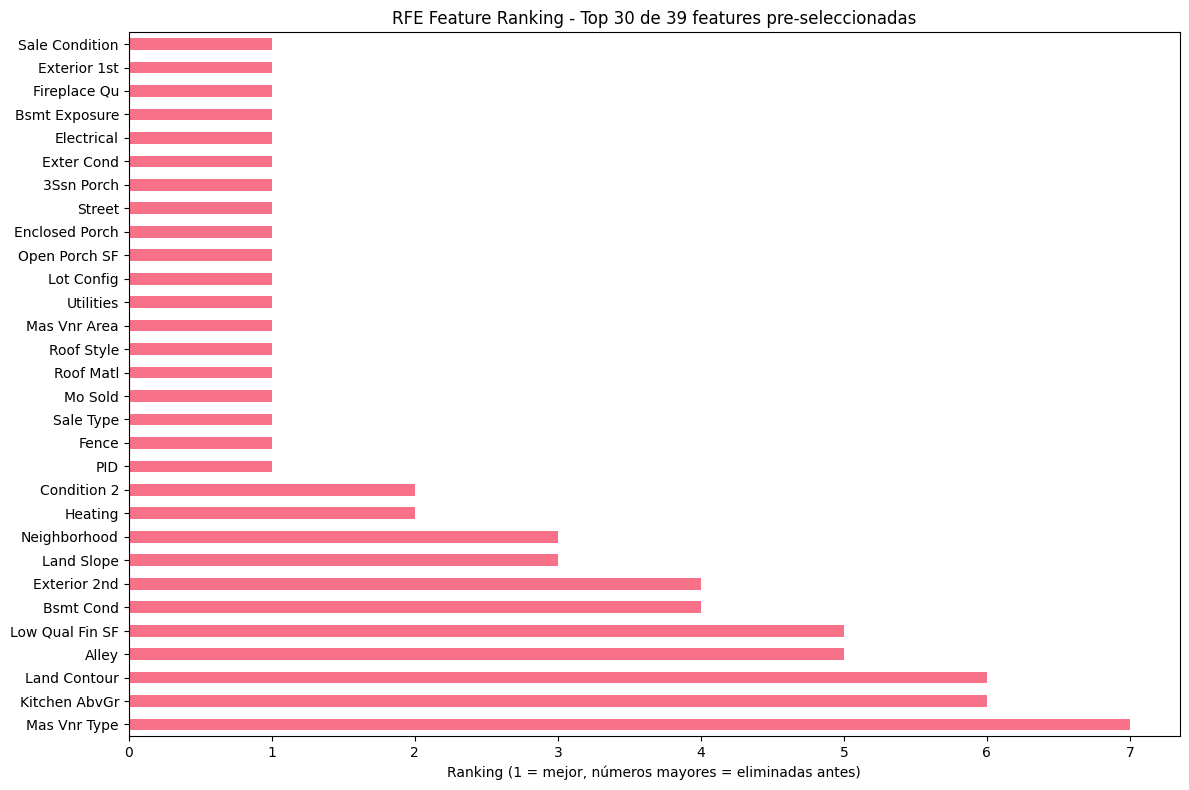

In [23]:
from sklearn.feature_selection import RFE

# ========== TWO-STAGE SELECTION: PCA + RFE ==========
print("\n=== WRAPPER METHOD: RFE (Recursive Feature Elimination) ===")
print("💡 ESTRATEGIA: RFE sobre features pre-seleccionadas por PCA")
print(f"   Stage 1 (ya hecho): PCA Loadings → {len(selected_features_pca)} features")
print(f"   Stage 2 (ahora): RFE → refinar a {k_wrapper} features")
print("⏱️ Esto tomará ~45-90 segundos...\n")

# TODO: RFE con Random Forest Regressor sobre features pre-seleccionadas
estimator = RandomForestRegressor(
    random_state=42, 
    n_estimators=50,
    max_depth=10,
    n_jobs=-1
)
selector_rfe = RFE(estimator=estimator, n_features_to_select=k_wrapper, step=2)

print(f"🔄 Ejecutando RFE sobre {len(selected_features_pca)} features...")
import time
start_time = time.time()
X_rfe = selector_rfe.fit_transform(X_pca_selected, y)
elapsed_time = time.time() - start_time

print(f"✅ RFE completado en {elapsed_time:.1f} segundos")

# Features seleccionadas (mapear índices de vuelta a nombres)
selected_indices_rfe = selector_rfe.get_support()
selected_features_rfe = [selected_features_pca[i] for i, sel in enumerate(selected_indices_rfe) if sel]

print(f"\n✅ Features seleccionadas por RFE ({len(selected_features_rfe)}):")
for i, feat in enumerate(selected_features_rfe, 1):
    print(f"  {i:2d}. {feat}")

# Ranking de features (solo sobre las pre-seleccionadas por PCA)
ranking = pd.Series(selector_rfe.ranking_, index=selected_features_pca).sort_values()
print(f"\nRanking de features (1 = seleccionada, solo mostrando top 20):")
print(ranking.head(20))

# Visualizar ranking (top 30 para claridad)
plt.figure(figsize=(12, 8))
ranking.head(30).sort_values(ascending=False).plot(kind='barh')
plt.xlabel('Ranking (1 = mejor, números mayores = eliminadas antes)')
plt.title(f'RFE Feature Ranking - Top 30 de {len(selected_features_pca)} features pre-seleccionadas')
plt.tight_layout()
plt.show()

## Paso 4.4: Comparación de Features Seleccionadas (Todos los Wrapper Methods)

In [24]:
# Comparar features seleccionadas por diferentes métodos
print("\n=== COMPARACIÓN DE FEATURES SELECCIONADAS ===")

# Crear conjunto de features por método
features_dict = {
    'F-test': set(selected_features_f),
    'Mutual Info': set(selected_features_mi),
    'Forward': set(selected_features_forward),
    'Backward': set(selected_features_backward),
    'RFE': set(selected_features_rfe)
}

# Features en al menos 2 métodos
all_features = set()
for features in features_dict.values():
    all_features.update(features)

feature_counts = {}
for feature in all_features:
    count = sum(1 for features in features_dict.values() if feature in features)
    feature_counts[feature] = count

# Features consistentes (en todos los métodos)
consistent_features = [f for f, count in feature_counts.items() if count == 3]
print(f"\nFeatures consistentes (en todos los métodos): {len(consistent_features)}")
print(consistent_features)

# Features en al menos 2 métodos
robust_features = [f for f, count in feature_counts.items() if count >= 2]
print(f"\nFeatures robustas (≥2 métodos): {len(robust_features)}")
print(robust_features)

print("\n💡 OBSERVACIÓN:")
print(f"   Forward, Backward y RFE son todos wrapper methods, pero usan estrategias diferentes")


=== COMPARACIÓN DE FEATURES SELECCIONADAS ===

Features consistentes (en todos los métodos): 11
['Open Porch SF', 'Wood Deck SF', 'Electrical', 'Bsmt Exposure', 'Roof Matl', 'Exterior 2nd', 'Street', '3Ssn Porch', 'Enclosed Porch', 'PID', 'Exterior 1st']

Features robustas (≥2 métodos): 49
['TotRms AbvGrd', 'Overall Qual', '1st Flr SF', 'Exter Cond', 'Lot Config', 'Fence', 'Bsmt Qual', 'Garage Finish', 'Garage Area', 'Garage Cond', 'Bsmt Unf SF', 'Full Bath', 'Neighborhood', 'Open Porch SF', 'Total Bsmt SF', 'Sale Type', 'Garage Yr Blt', 'Fireplaces', 'Year Remod/Add', 'Wood Deck SF', 'Electrical', 'Bsmt Exposure', 'Roof Matl', 'Lot Area', 'Exter Qual', 'Sale Condition', 'Year Built', 'Garage Cars', 'Exterior 2nd', 'Street', 'BsmtFin SF 1', '3Ssn Porch', 'Lot Frontage', 'Mo Sold', 'Roof Style', 'Foundation', 'Enclosed Porch', 'Overall Cond', 'PID', '2nd Flr SF', 'Gr Liv Area', 'Land Slope', 'Mas Vnr Area', 'Heating QC', 'Fireplace Qu', 'Exterior 1st', 'Mas Vnr Type', 'Garage Type', 'K

## 🤔 Pregunta Reflexiva 10:

1. ¿Cuánto tiempo tomaron los wrapper methods (Forward, Backward, RFE) vs Filter Methods?
2. ¿Los 3 wrapper methods seleccionaron features similares? ¿Qué significa esto?
3. ¿Cuándo usarías Forward vs Backward vs RFE en un proyecto real?

## Paso 4.5: Evaluar Performance de Wrapper Methods

In [25]:
# ========== EVALUACIÓN: FORWARD SELECTION ==========
print("\n=== EVALUANDO WRAPPER METHODS ===")
print("⏱️ Cross-validation con features de cada método...\n")

print("🔄 Evaluando Forward Selection...")
rf_forward = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=15, n_jobs=-1)

scores_mse_forward = -cross_val_score(rf_forward, X_forward, y, cv=5, 
                                       scoring='neg_mean_squared_error', n_jobs=-1)
scores_r2_forward = cross_val_score(rf_forward, X_forward, y, cv=5, 
                                    scoring='r2', n_jobs=-1)
rmse_forward = np.sqrt(scores_mse_forward)

print(f"✅ Forward Selection ({len(selected_features_forward)} features):")
print(f"   RMSE: ${rmse_forward.mean():,.0f} ± ${rmse_forward.std():,.0f}")
print(f"   R²:   {scores_r2_forward.mean():.4f} ± {scores_r2_forward.std():.4f}")

# ========== EVALUACIÓN: BACKWARD ELIMINATION ==========
print(f"\n🔄 Evaluando Backward Elimination...")
rf_backward = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=15, n_jobs=-1)

scores_mse_backward = -cross_val_score(rf_backward, X_backward, y, cv=5, 
                                         scoring='neg_mean_squared_error', n_jobs=-1)
scores_r2_backward = cross_val_score(rf_backward, X_backward, y, cv=5, 
                                      scoring='r2', n_jobs=-1)
rmse_backward = np.sqrt(scores_mse_backward)

print(f"✅ Backward Elimination ({len(selected_features_backward)} features):")
print(f"   RMSE: ${rmse_backward.mean():,.0f} ± ${rmse_backward.std():,.0f}")
print(f"   R²:   {scores_r2_backward.mean():.4f} ± {scores_r2_backward.std():.4f}")

# ========== EVALUACIÓN: RFE ==========
print(f"\n🔄 Evaluando RFE...")
rf_rfe = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=15, n_jobs=-1)

scores_mse_rfe = -cross_val_score(rf_rfe, X_rfe, y, cv=5, 
                                   scoring='neg_mean_squared_error', n_jobs=-1)
scores_r2_rfe = cross_val_score(rf_rfe, X_rfe, y, cv=5, 
                                scoring='r2', n_jobs=-1)
rmse_rfe = np.sqrt(scores_mse_rfe)

print(f"✅ RFE ({len(selected_features_rfe)} features):")
print(f"   RMSE: ${rmse_rfe.mean():,.0f} ± ${rmse_rfe.std():,.0f}")
print(f"   R²:   {scores_r2_rfe.mean():.4f} ± {scores_r2_rfe.std():.4f}")

# ========== COMPARACIÓN ACTUALIZADA ==========
print(f"\n" + "="*80)
print(f"{'COMPARACIÓN: TODOS LOS MÉTODOS HASTA AHORA':^80}")
print(f"="*80)

comparison_updated = {
    'Método': ['Original', 'PCA Componentes', 'PCA Loadings', 'F-test', 'MI', 'Forward', 'Backward', 'RFE'],
    'N_Features': [X.shape[1], n_components_80, k, k, k, k, k, k],
    'RMSE': [rmse_original.mean(), rmse_pca.mean(), rmse_pca_selected.mean(), rmse_filter_f.mean(), 
             rmse_filter_mi.mean(), rmse_forward.mean(), rmse_backward.mean(), rmse_rfe.mean()],
    'R²': [scores_r2_original.mean(), scores_r2_pca.mean(), scores_r2_pca_selected.mean(), scores_r2_filter_f.mean(), 
           scores_r2_filter_mi.mean(), scores_r2_forward.mean(), scores_r2_backward.mean(), scores_r2_rfe.mean()]
}
comparison_updated_df = pd.DataFrame(comparison_updated)
comparison_updated_df['Reducción%'] = (1 - comparison_updated_df['N_Features'] / X.shape[1]) * 100
comparison_updated_df = comparison_updated_df.sort_values('RMSE')

print(f"\n{comparison_updated_df.to_string(index=False)}")

print(f"\n💡 OBSERVACIÓN:")
best_method = comparison_updated_df.iloc[0]['Método']
best_rmse = comparison_updated_df.iloc[0]['RMSE']
print(f"   🏆 Mejor RMSE: {best_method} (${best_rmse:,.0f})")


=== EVALUANDO WRAPPER METHODS ===
⏱️ Cross-validation con features de cada método...

🔄 Evaluando Forward Selection...
✅ Forward Selection (19 features):
   RMSE: $40,768 ± $2,483
   R²:   0.7357 ± 0.0232

🔄 Evaluando Backward Elimination...
✅ Backward Elimination (19 features):
   RMSE: $41,788 ± $3,858
   R²:   0.7228 ± 0.0335

🔄 Evaluando RFE...
✅ RFE (19 features):
   RMSE: $41,767 ± $3,957
   R²:   0.7230 ± 0.0355

                   COMPARACIÓN: TODOS LOS MÉTODOS HASTA AHORA                   

         Método  N_Features         RMSE       R²  Reducción%
             MI          39 26136.649047 0.890305   51.851852
         F-test          39 26494.415957 0.887486   51.851852
PCA Componentes          39 26715.126553 0.884999   51.851852
       Original          81 26806.916950 0.884739    0.000000
        Forward          39 40767.583301 0.735732   51.851852
            RFE          39 41767.156206 0.722980   51.851852
   PCA Loadings          39 41772.530314 0.722896   51.8518

## Parte 5: Feature Selection - Embedded Methods (15 min)

### Paso 5.1: Random Forest Feature Importance


=== EMBEDDED METHODS: Random Forest ===
Top 10 features por importancia:
Order            0.039088
Gr Liv Area      0.038188
PID              0.037478
1st Flr SF       0.034780
Lot Area         0.034026
Garage Area      0.033741
Total Bsmt SF    0.031102
Year Built       0.030783
Bsmt Unf SF      0.030057
Garage Yr Blt    0.028485
dtype: float64


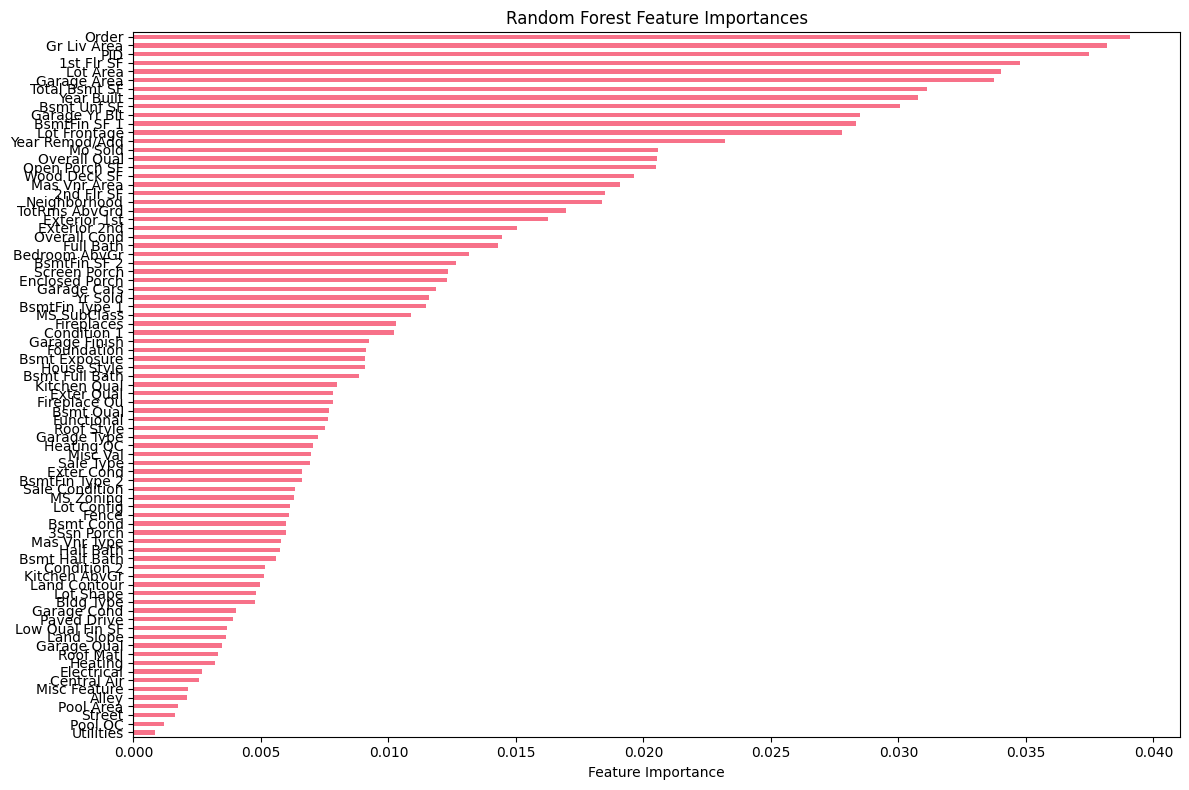


Features seleccionadas por RF Importance (39):
['Order', 'Gr Liv Area', 'PID', '1st Flr SF', 'Lot Area', 'Garage Area', 'Total Bsmt SF', 'Year Built', 'Bsmt Unf SF', 'Garage Yr Blt', 'BsmtFin SF 1', 'Lot Frontage', 'Year Remod/Add', 'Mo Sold', 'Overall Qual', 'Open Porch SF', 'Wood Deck SF', 'Mas Vnr Area', '2nd Flr SF', 'Neighborhood', 'TotRms AbvGrd', 'Exterior 1st', 'Exterior 2nd', 'Overall Cond', 'Full Bath', 'Bedroom AbvGr', 'BsmtFin SF 2', 'Screen Porch', 'Enclosed Porch', 'Garage Cars', 'Yr Sold', 'BsmtFin Type 1', 'MS SubClass', 'Fireplaces', 'Condition 1', 'Garage Finish', 'Foundation', 'Bsmt Exposure', 'House Style']

RMSE RF Importance (39 features): $41,736 ± $4,325

RF Importance (39 features):
  Mean: 0.025
  Std: 0.004


In [26]:
# TODO: Entrenar Random Forest y obtener importances
print("\n=== EMBEDDED METHODS: Random Forest ===")
from sklearn.ensemble import RandomForestClassifier

rf_embedded = RandomForestClassifier(random_state=42, n_estimators=200, max_depth=10)
rf_embedded.fit(X_scaled, y)

# Feature importances
importances = pd.Series(rf_embedded.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Top 10 features por importancia:")
print(importances.head(10))

# Visualizar importances
plt.figure(figsize=(12, 8))
importances.sort_values(ascending=True).plot(kind='barh')
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importances')
plt.tight_layout()
plt.show()

# TODO: Seleccionar top-k features
top_k_features = importances.nlargest(k).index
X_rf_importance = X_scaled[:, X.columns.isin(top_k_features)]

print(f"\nFeatures seleccionadas por RF Importance ({k}):")
print(list(top_k_features))

# Evaluar
rmse_rf_importance = np.sqrt(-cross_val_score(rf_embedded, X_rf_importance, y, cv=5, scoring='neg_mean_squared_error'))
print(f"\nRMSE RF Importance ({k} features): ${rmse_rf_importance.mean():,.0f} ± ${rmse_rf_importance.std():,.0f}")
scores_rf_importance = cross_val_score(rf_embedded, X_rf_importance, y, cv=5, scoring='accuracy')
print(f"\nRF Importance ({k} features):")
print(f"  Mean: {scores_rf_importance.mean():.3f}")
print(f"  Std: {scores_rf_importance.std():.3f}")

## Paso 5.2: Lasso (L1 Regularization para Regresión)


=== EMBEDDED METHOD: Lasso (L1 Regularization) ===
Lasso penaliza coeficientes, forzando a 0 features no importantes
⏱️ Esto puede tomar 30-60 segundos...

✅ Lasso alpha seleccionado: 1375.3800

📊 Features con coeficiente no-cero: 41 de 81

✅ Top 39 features por magnitud de coeficiente Lasso:
   1. Gr Liv Area         : |23965.928207|
   2. Overall Qual        : |18865.442199|
   3. Exter Qual          : |7716.360557|
   4. Bsmt Qual           : |6329.475846|
   5. BsmtFin SF 1        : |5992.855445|
   6. Kitchen Qual        : |5700.002821|
   7. MS SubClass         : |5239.648051|
   8. Year Built          : |4413.604581|
   9. Mas Vnr Area        : |3986.298254|
  10. Fireplaces          : |3714.132817|
  11. Garage Cars         : |3635.912839|
  12. Misc Val            : |3352.852943|
  13. Bsmt Exposure       : |3248.117435|
  14. Overall Cond        : |3078.550394|
  15. Garage Area         : |3068.732335|
  16. Lot Area            : |2623.674245|
  17. Total Bsmt SF       : |25

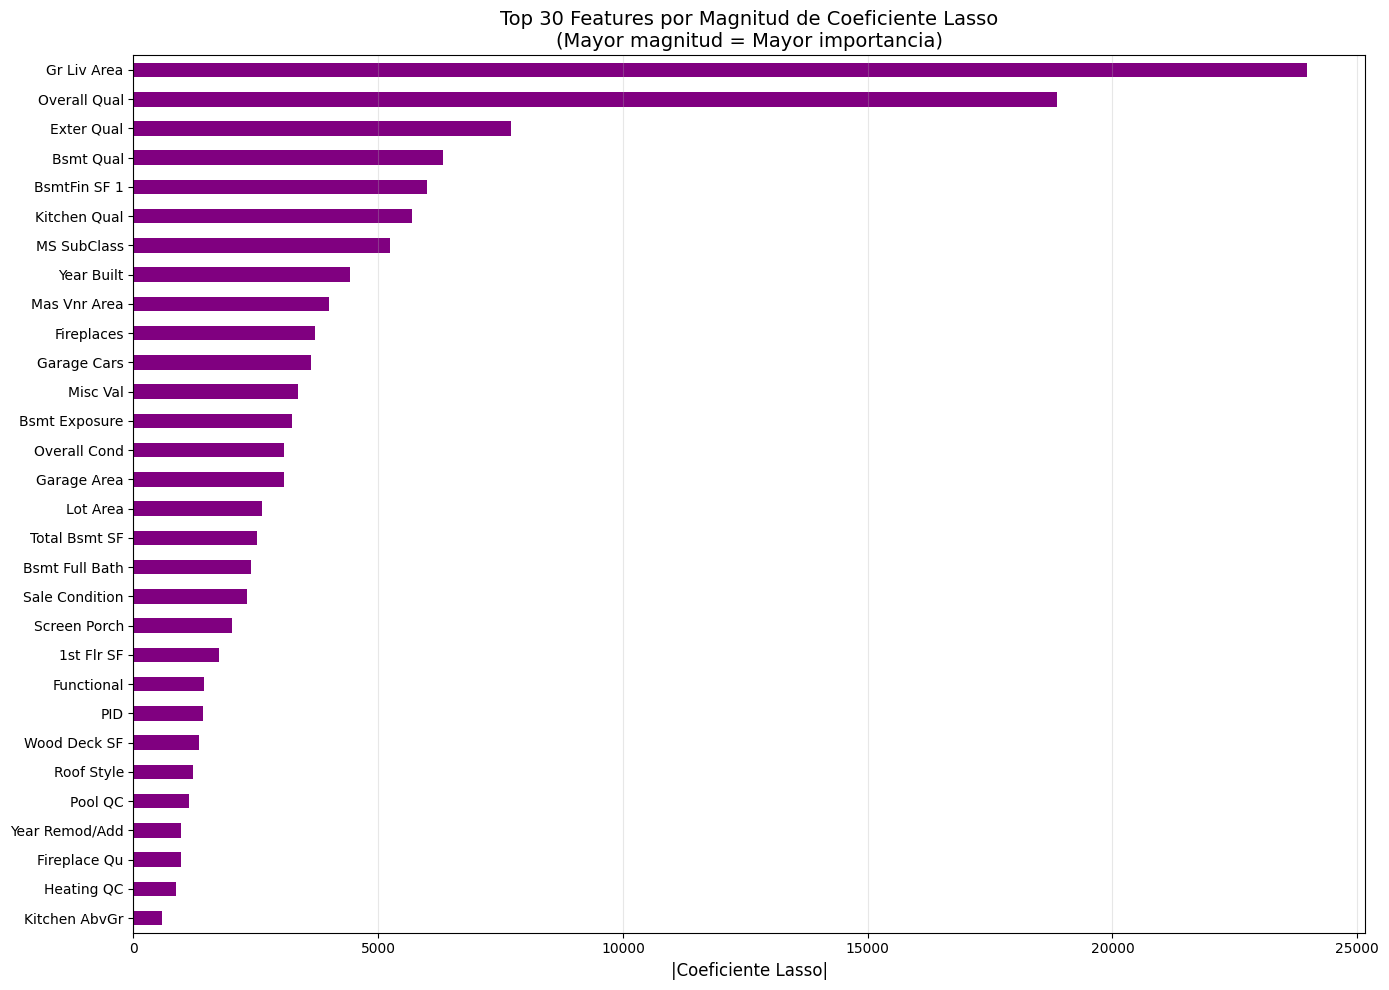


🔄 Evaluando Lasso selection...
✅ Lasso selection (39 features):
   RMSE: $26,189 ± $4,421
   R²:   0.8899 ± 0.0312


In [27]:
from sklearn.linear_model import LassoCV

# ========== LASSO PARA FEATURE SELECTION ==========
print("\n=== EMBEDDED METHOD: Lasso (L1 Regularization) ===")
print("Lasso penaliza coeficientes, forzando a 0 features no importantes")
print("⏱️ Esto puede tomar 30-60 segundos...\n")

# TODO: Lasso para regresión
lasso = LassoCV(cv=5, random_state=42, max_iter=10000)
lasso.fit(X_scaled, y)

print(f"✅ Lasso alpha seleccionado: {lasso.alpha_:.4f}")

# Features seleccionadas (coef != 0)
lasso_nonzero = X.columns[lasso.coef_ != 0]
print(f"\n📊 Features con coeficiente no-cero: {len(lasso_nonzero)} de {X.shape[1]}")

# Seleccionar top-k por magnitud de coeficiente
coef_abs = pd.Series(np.abs(lasso.coef_), index=X.columns).sort_values(ascending=False)
lasso_features = coef_abs.nlargest(k).index

print(f"\n✅ Top {k} features por magnitud de coeficiente Lasso:")
for i, (feat, coef) in enumerate(coef_abs.nlargest(k).items(), 1):
    print(f"  {i:2d}. {feat:20s}: |{coef:.6f}|")

# TODO: Visualizar coeficientes (top 30)
plt.figure(figsize=(14, 10))
coef_abs.head(30).sort_values(ascending=True).plot(kind='barh', color='purple')
plt.xlabel('|Coeficiente Lasso|', fontsize=12)
plt.title('Top 30 Features por Magnitud de Coeficiente Lasso\n(Mayor magnitud = Mayor importancia)', fontsize=14)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Preparar features para evaluación
X_lasso = X_scaled[:, X.columns.isin(lasso_features)]

# ========== EVALUAR CON RANDOM FOREST ==========
print(f"\n🔄 Evaluando Lasso selection...")
rf_lasso = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=15, n_jobs=-1)

scores_mse_lasso = -cross_val_score(rf_lasso, X_lasso, y, cv=5, 
                                     scoring='neg_mean_squared_error', n_jobs=-1)
scores_r2_lasso = cross_val_score(rf_lasso, X_lasso, y, cv=5, 
                                  scoring='r2', n_jobs=-1)
rmse_lasso = np.sqrt(scores_mse_lasso)

print(f"✅ Lasso selection ({k} features):")
print(f"   RMSE: ${rmse_lasso.mean():,.0f} ± ${rmse_lasso.std():,.0f}")
print(f"   R²:   {scores_r2_lasso.mean():.4f} ± {scores_r2_lasso.std():.4f}")

# 📝 Reflexión Final Integradora (OBLIGATORIO)

## ⏱️ Tiempo estimado: 15-20 minutos

Responde las siguientes preguntas en una celda Markdown al final de tu notebook. Estas preguntas te ayudarán a consolidar tu comprensión y demostrar pensamiento crítico.

## A. Sobre PCA

1. Interpretabilidad: ¿Puedes explicar en términos simples qué representa PC1 en el contexto de precios de casas? ¿Es esto útil para un agente inmobiliario?
- PC1 representa una combinación de variables que reflejan principalmente el tamaño y la calidad general de las viviendas: superficie, materiales, terminaciones, entre otros. En términos simples, es una medida sintética del “nivel” o “categoría” de la propiedad. Para un agente inmobiliario, esto puede ser muy útil, ya que resume en un solo número el perfil global de una casa, facilitando la comparación entre propiedades.
2. Varianza Explicada: Si PC1 captura 40% de varianza, ¿qué significa esto exactamente? ¿Qué información se "pierde" en el 60% restante?
- Si PC1 captura el 40% de la varianza, significa que casi la mitad de la información del dataset puede resumirse en ese primer componente. El 60% restante contiene detalles más específicos o variaciones menores entre las viviendas. En otras palabras, perdemos parte de la fineza o matices de los datos, pero conservamos la estructura principal.
3. Cuándo usar PCA: Menciona 3 escenarios reales donde PCA sería MÁS útil que Feature Selection (no en este dataset, sino en general).
- Cuando hay muchas variables numéricas correlacionadas y se busca reducir la dimensionalidad sin perder demasiada información.
4. Limitaciones: ¿Cuál es la mayor desventaja de PCA para este problema de bienes raíces?
- La principal desventaja del PCA en este contexto es la falta de interpretabilidad directa. Los componentes son combinaciones matemáticas que no se pueden traducir fácilmente a variables concretas del negocio, lo que dificulta explicar los resultados a agentes o clientes no técnicos.
## B. Sobre Feature Selection

1. Consistencia: Si F-test, MI, RFE y Lasso eligieron features diferentes, ¿cómo decides cuál conjunto usar? ¿Qué estrategia aplicarías?
- Si los distintos métodos eligen features diferentes, combinaría la información aplicando una estrategia híbrida: priorizaría las variables que aparecen con más frecuencia entre los métodos y validaría su desempeño con cross-validation. En definitiva, elegiría el conjunto que logre el mejor equilibrio entre rendimiento y sentido interpretativo.  
2. Features Redundantes: Si GarageArea y GarageCars están altamente correlacionadas, ¿cuál deberías eliminar? ¿Cómo decides?
- Si GarageArea y GarageCars están altamente correlacionadas,probablemente me quedaria con la que captura la misma información de forma más directa. La decisión se basa en la interpretabilidad y la relevancia práctica para el negocio
3. Métodos Filter vs Wrapper: ¿Por qué RFE es más lento que F-test? ¿Cuándo justifica el tiempo extra?
- RFE (Recursive Feature Elimination) es más lento que F-test porque entrena un modelo varias veces, eliminando variables paso a paso según su impacto en el rendimiento. Justifica el tiempo extra cuando se busca máxima precisión y selección óptima de features específicas para un modelo dado, en lugar de una evaluación estadística más general.
4. Lasso Shrinkage: Si Lasso forzó 40 features a coeficiente 0, ¿qué te dice esto sobre la redundancia en el dataset?
- Indica que hay mucha redundancia o irrelevancia en el dataset. Significa que solo una parte de las variables realmente aporta información nueva al modelo, y el resto puede eliminarse sin afectar significativamente la capacidad predictiva.